# 📊 1. Business Understanding

## 🎯 Project Objective
This project aims to enhance **family planning (FP)** service delivery efficiency in **Kenya** by leveraging **machine learning** for accurate demand forecasting. The forecasts will support **data-driven resource allocation**, ultimately improving **maternal and child health outcomes**.

---

## 🔍 Key Forecasting Targets

- **Total FP**: Overall family planning service uptake.
- **FP Method Band Projections**:
  - Pills (Oral Contraceptives - OCs)
  - Condoms (Male & Female)
  - Injectables
  - Implants
  - IUDs (Intrauterine Devices)
  - Surgical methods (Sterilization)
- **New Users**: Individuals initiating FP services.
- **Continuing Users (Revisits)**: Individuals returning for follow-up/re-supply.
- **Adolescents (10–24) Receiving FP Services**: Age-specific uptake.
- **Adults (25+) Receiving FP Services**: Age-specific uptake.
- **FP Commodity Required**: Derived from projected demand, current stock, and buffer needs.

---

## 📈 Success Metrics (Model Performance)

To evaluate forecasting accuracy and reliability, the following metrics will be used:

### 🔹 Mean Absolute Error (MAE)
- Measures the average magnitude of forecast errors in the same units as the target.
- Lower MAE = better accuracy.
- Computed using:  
  `ke_fp_service_data.csv` and `ke_fp_commodity_data.csv`.

### 🔹 Root Mean Squared Error (RMSE)
- Penalizes larger errors more than MAE.
- Useful when large deviations (e.g., stockouts or overstocking) are critical.
- Lower RMSE = fewer large mistakes.

### 🔹 Mean Absolute Percentage Error (MAPE)
- Expresses average forecast error as a percentage.
- Allows comparison across targets with different scales.
- Caution: MAPE may be unstable when actual demand is very low or zero.

> All metrics will be evaluated on a **held-out test set** and monitored **post-deployment** using actual data.

---

## 📂 Data Sources

| File | Description |
|------|-------------|
| `ke_fp_service_data.csv` | FP service attendance, new/revisit clients, age disaggregation |
| `ke_fp_commodity_data.csv` | Commodity dispensing data and stock levels |
| `ke_fp_population_data.csv` | Population demographics (e.g., women of childbearing age) |
| `ke_fp_benchmarks_core_health_workforce.csv` | Health workforce benchmarks |
| `ke_fp_benchmarks_Demand_Satisfied.csv` | Demand satisfied benchmarks |
| `ke_fp_benchmarks_mCPR.csv` | Modern Contraceptive Prevalence Rate benchmarks |
| `ke_fp_benchmarks_Total_Unmet_Need_MW.csv` | Total unmet need benchmarks |

---

## ✅ Summary
This phase defines **what success looks like**: reliable and interpretable forecasts of FP demand by method and population segment. These insights will guide national and county-level health managers in **allocating resources proactively**, preventing **stockouts**, and ensuring **continuity of care** in family planning services.



In [37]:
# pip install -r requirements.txt

# 🛠️ 2. Data Preparation - Imports and Initial Setup

In this section, we load all essential Python libraries and set up the environment for data ingestion, model interaction, and visualization. This includes creating necessary directories, loading the pre-trained model, and defining helper functions to manage the data pipeline.

---

## 📦 Library Imports

We use a diverse set of libraries for:

- **Data manipulation**: `pandas`, `numpy`
- **Visualization**: `matplotlib`, `seaborn`, `plotly`
- **Modeling**: `scikit-learn`, `tensorflow.keras`
- **Application deployment**: `streamlit`
- **Utilities**: `os`, `re`, `warnings`, `joblib`, `io`

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import io
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

import plotly.express as px
import streamlit as st


## Imports and Initial Setup

In [ ]:
## Imports and Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import plotly.express as px
import streamlit as st 
import io
import os
import re
import plotly.express as px
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
model = load_model("models/fp_lstm_model.h5", custom_objects={"mse": MeanSquaredError()})
warnings.filterwarnings('ignore')

# Create 'data' and 'data/benchmarks' directories if they don't exist
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('data/benchmarks'):
    os.makedirs('data/benchmarks')



full_data_df = None




def load_all_data():
    """Loads all CSV datasets into pandas DataFrames from the 'data' and 'data/benchmarks' directories."""
    data_dir = "data/"
    benchmarks_dir = "data/benchmarks/"

    # Directly load the provided CSV files
    df_population = pd.read_csv(f"{data_dir}ke_fp_population_data.csv", encoding='latin1')
    df_service = pd.read_csv(f"{data_dir}ke_fp_service_data.csv", encoding='latin1')
    df_commodity = pd.read_csv(f"{data_dir}ke_fp_commodity_data.csv", encoding='latin1')

    df_core_health_workforce = pd.read_csv(f"{benchmarks_dir}ke_fp_benchmarks_core_health_workforce.csv", encoding='latin1')
    df_demand_satisfied = pd.read_csv(f"{benchmarks_dir}ke_fp_benchmarks_Demand_Satisfied.csv", encoding='latin1')
    df_mcpr = pd.read_csv(f"{benchmarks_dir}ke_fp_benchmarks_mCPR.csv", encoding='latin1')
    df_unmet_need = pd.read_csv(f"{benchmarks_dir}ke_fp_benchmarks_Total_Unmet_Need_MW.csv", encoding='latin1')

    return df_population, df_service, df_commodity, df_core_health_workforce, df_demand_satisfied, df_mcpr, df_unmet_need


# 📈 3. Data Understanding - Cleaning, merging and initial feature engineering

## 📂 Data Sources Overview


In this phase, we explore and validate the datasets that drive the forecasting model.

## 📂 Data Sources Overview

| Dataset | Description |
|---------|-------------|
| `ke_fp_population_data.csv` | Population-level data including women of reproductive age by county and age group |
| `ke_fp_service_data.csv` | Monthly FP service attendance (new/revisit), method used, age group, and geographic disaggregation |
| `ke_fp_commodity_data.csv` | Stocks issued, available stock levels, and reported shortages per method |
| `ke_fp_benchmarks_core_health_workforce.csv` | Staffing ratios for healthcare service provision |
| `ke_fp_benchmarks_Demand_Satisfied.csv` | Benchmarks for demand satisfied by modern methods |
| `ke_fp_benchmarks_mCPR.csv` | Modern Contraceptive Prevalence Rate per county |
| `ke_fp_benchmarks_Total_Unmet_Need_MW.csv` | Unmet FP needs among women in reproductive age |

## 🧪 Key Checks Performed

- Verified completeness and consistency across monthly reporting periods and counties
- Validated disaggregation logic (age, method, user type)
- Identified and flagged outliers, such as unusually high service uptake in small population areas
- Cross-referenced stockout and service disruption patterns

In [39]:

# Load dataframes
df_population, df_service, df_commodity, df_core_health_workforce, df_demand_satisfied, df_mcpr, df_unmet_need = load_all_data()

print("--- Initial Data Inspection (df_service) ---")
print(df_service.info())
print("\nMissing values (df_service):\n", df_service.isnull().sum().head())
print("\nDescriptive statistics (df_service):\n", df_service.describe().T.head())

print("\n--- Initial Data Inspection (df_commodity) ---")
print(df_commodity.info())
print("\nMissing values (df_commodity):\n", df_commodity.isnull().sum().head())
print("\nDescriptive statistics (df_commodity):\n", df_commodity.describe().T.head())

print("\n--- Initial Data Inspection (df_population) ---")
print(df_population.info())
print("\nMissing values (df_population):\n", df_population.isnull().sum().head())
print("\nDescriptive statistics (df_population):\n", df_population.describe().T.head())

print("\n--- Initial Data Inspection (df_core_health_workforce) ---")
print(df_core_health_workforce.info())
print("\nMissing values (df_core_health_workforce):\n", df_core_health_workforce.isnull().sum().head())
print("\nDescriptive statistics (df_core_health_workforce):\n", df_core_health_workforce.describe().T.head())

print("\n--- Initial Data Inspection (df_demand_satisfied) ---")
print(df_demand_satisfied.info())
print("\nMissing values (df_demand_satisfied):\n", df_demand_satisfied.isnull().sum().head())
print("\nDescriptive statistics (df_demand_satisfied):\n", df_demand_satisfied.describe().T.head())

print("\n--- Initial Data Inspection (df_mcpr) ---")
print(df_mcpr.info())
print("\nMissing values (df_mcpr):\n", df_mcpr.isnull().sum().head())
print("\nDescriptive statistics (df_mcpr):\n", df_mcpr.describe().T.head())

print("\n--- Initial Data Inspection (df_unmet_need) ---")
print(df_unmet_need.info())
print("\nMissing values (df_unmet_need):\n", df_unmet_need.isnull().sum().head())
print("\nDescriptive statistics (df_unmet_need):\n", df_unmet_need.describe().T.head())

--- Initial Data Inspection (df_service) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 60 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   periodid                                                                        2820 non-null   int64  
 1   periodname                                                                      2820 non-null   object 
 2   periodcode                                                                      2820 non-null   int64  
 3   perioddescription                                                               0 non-null      float64
 4   orgunitlevel1                                                                   2820 non-null   object 
 5   orgunitlevel2                                                                   

## Data cleaning

In [40]:

# DataFrames: df_population, df_service, df_commodity, df_core_health_workforce, df_demand_satisfied, df_mcpr, df_unmet_need
print("Step 3.1: Copying raw dataframes for processing.")
df_service_proc = df_service.copy()
df_commodity_proc = df_commodity.copy()
df_population_proc = df_population.copy()
df_core_health_workforce_proc = df_core_health_workforce.copy()
df_demand_satisfied_proc = df_demand_satisfied.copy()
df_mcpr_proc = df_mcpr.copy()
df_unmet_need_proc = df_unmet_need.copy()


Step 3.1: Copying raw dataframes for processing.


In [74]:
# Helper function to standardize column names
def standardize_col_labels(df):
    """
    Standardizes column names by:
    - Removing common prefixes like 'MOH 711 Rev', 'MOH_711', etc.
    - Lowercasing all names
    - Replacing special characters with underscores
    - Removing remaining non-alphanumeric characters (except underscore and dot)
    - Stripping and collapsing underscores
    """
    def clean_column(col):
        col = col.lower()
        col = re.sub(r'^moh[\s_]*711[\s_]*(rev)?[\s_]*[0-9]*[\s_]*', '', col)
        col = col.replace('–', '_').replace('â', '_')  
        col = col.replace('(', '_').replace(')', '_').replace('%', '_percent').replace(',', '_')
        col = col.replace(' ', '_').replace('-', '_').replace('+', '_plus')
        col = re.sub(r'[^a-z0-9_.]', '', col)
        col = re.sub(r'_+', '_', col).strip('_')
        return col

    df.columns = [clean_column(col) for col in df.columns]
    return df

# Process all relevant dataframes
df_service_proc = standardize_col_labels(df_service.copy())
df_commodity_proc = standardize_col_labels(df_commodity.copy())
df_population_proc = standardize_col_labels(df_population.copy())
df_core_health_workforce_proc = standardize_col_labels(df_core_health_workforce.copy())
df_demand_satisfied_proc = standardize_col_labels(df_demand_satisfied.copy())
df_mcpr_proc = standardize_col_labels(df_mcpr.copy())
df_unmet_need_proc = standardize_col_labels(df_unmet_need.copy())

# Output standardized column names
print("df_service_proc:", df_service_proc.columns.tolist())
print("df_commodity_proc:", df_commodity_proc.columns.tolist())
print("df_population_proc:", df_population_proc.columns.tolist())
print("df_core_health_workforce_proc:", df_core_health_workforce_proc.columns.tolist())
print("df_demand_satisfied_proc:", df_demand_satisfied_proc.columns.tolist())
print("df_mcpr_proc:", df_mcpr_proc.columns.tolist())
print("df_unmet_need_proc:", df_unmet_need_proc.columns.tolist())



df_service_proc: ['periodid', 'periodname', 'periodcode', 'perioddescription', 'orgunitlevel1', 'orgunitlevel2', 'organisationunitid', 'organisationunitname', 'organisationunitcode', 'organisationunitdescription', 'estimated_number_of_pregnant_women', 'fp_attendance_new_clients', 'fp_attendance_re_visits', 'adolescent_10_14_yrs_receiving_fp_services_new_clients', 'adolescent_10_14_yrs_receiving_fp_services_re_visits', 'adolescent_15_19_yrs_receiving_fp_services_new_clients', 'adolescent_15_19_yrs_receiving_fp_services_re_visits', 'adolescent_20_24_yrs_receiving_fp_services_new_clients', 'adolescent_20_24_yrs_receiving_fp_services_re_visits', 'client_receiving_male_condoms_new_clients', 'client_receiving_male_condoms_re_visits', 'clients_counselled_natural_family_planning_new_clients', 'clients_counselled_natural_family_planning_re_visits', 'clients_receiving_female_condoms_new_clients', 'clients_receiving_female_condoms_re_visits', 'emergency_contraceptive_pill_new_clients', 'emergency

In [42]:
# --- Individual DataFrame Cleaning and Standardization ---

# Step 3.2.1: Clean and Standardize df_service_proc
print("\nStep 3.2.1: Cleaning and standardizing 'df_service_proc'.")
# Apply column label standardization
# Drop all-null columns
df_service_proc = df_service_proc.dropna(axis=1, how='all')
# Drop specific unwanted columns
df_service_proc = df_service_proc.drop(columns=[
    'periodid', 'organisationunitname', 'periodname',
    'population_growth_rate', 'total_population', 'women_of_childbearing_age_15_49yrs'
], axis=1, errors='ignore')
# Fill missing values (NaNs) with zeros
df_service_proc = df_service_proc.fillna(0)
# Convert appropriate columns to integer types
float_cols_service = df_service_proc.select_dtypes(include=['float', 'float64']).columns
df_service_proc[float_cols_service] = df_service_proc[float_cols_service].astype('int64')
# Process date/period columns and create UIDs
df_service_proc['periodcode'] = df_service_proc['periodcode'].astype('int64')

df_service_proc['year_month'] = df_service_proc['periodcode'].astype(str)
df_service_proc['year'] = df_service_proc['year_month'].str[:4]
df_service_proc['uid_code'] = df_service_proc[['year_month', 'organisationunitid']].astype(str).agg('_'.join, axis=1)
df_service_proc['uid_year'] = df_service_proc[['year', 'organisationunitid']].astype(str).agg('_'.join, axis=1)


if 'women_of_childbearing_age_1549yrs' in df_service_proc.columns:
    df_service_proc = df_service_proc.rename(columns={'women_of_childbearing_age_1549yrs': 'women_of_childbearing_age_15_49yrs'})
elif 'women_of_childbearing_age_15_49yrs' not in df_service_proc.columns:
    print("Warning: 'women_of_childbearing_age_15_49yrs' or its variant not found in df_service_proc.")


print("  'df_service_proc' after initial cleaning and UID creation:")
print(df_service_proc.head())
print(df_service_proc.info())



Step 3.2.1: Cleaning and standardizing 'df_service_proc'.
  'df_service_proc' after initial cleaning and UID creation:
   periodcode orgunitlevel1    orgunitlevel2 organisationunitid  \
0      202004         Kenya  Laikipia County        xuFdFy6t9AH   
1      202004         Kenya  Machakos County        yhCUgGcCcOo   
2      202004         Kenya    Kilifi County        nrI2khZx3d0   
3      202004         Kenya   Kericho County        ihZsJ8alvtb   
4      202004         Kenya    Isiolo County        bzOfj0iwfDH   

  organisationunitcode  estimated_number_of_pregnant_women  \
0         KE_County_31                               17003   
1         KE_County_16                               34245   
2          KE_County_3                               53527   
3         KE_County_35                               27857   
4         KE_County_11                               24514   

   fp_attendance_new_clients  fp_attendance_re_visits  \
0                        957                   

In [43]:

# Step 3.2.2: Clean and Standardize df_commodity_proc
print("\nStep 3.2.2: Cleaning and standardizing 'df_commodity_proc'.")
df_commodity_proc = df_commodity_proc.dropna(axis=1, how='all')
df_commodity_proc = df_commodity_proc.fillna(0)
float_cols_commodity = df_commodity_proc.select_dtypes(include=['float', 'float64']).columns
df_commodity_proc[float_cols_commodity] = df_commodity_proc[float_cols_commodity].astype('int64')
# Print columns to debug
print("Commodity columns after standardization:", df_commodity_proc.columns.tolist())

# Process date/period columns and create UIDs
df_commodity_proc['periodcode'] = df_commodity_proc['periodcode'].astype(str)
df_commodity_proc['uid_code'] = df_commodity_proc[['periodcode', 'organisationunitid']].astype(str).agg('_'.join, axis=1)
df_commodity_proc['year'] = df_commodity_proc['periodcode'].str[:4]
print("  'df_commodity_proc' after initial cleaning:")
print(df_commodity_proc.head())
print(df_commodity_proc.info())


Step 3.2.2: Cleaning and standardizing 'df_commodity_proc'.
Commodity columns after standardization: ['periodid', 'periodname', 'periodcode', 'orgunitlevel1', 'orgunitlevel2', 'organisationunitid', 'organisationunitname', 'organisationunitcode', 'pills_combined_oral_contraceptive_stock_losses', 'pills_combined_oral_contraceptive_stock_dispensed', 'pills_combined_oral_contraceptive_stock_at_hand', 'pills_combined_oral_contraceptive_stock_requested', 'pills_combined_oral_contraceptive_stock_received', 'pills_emergency_pill_stock_losses', 'pills_emergency_pill_stock_dispensed', 'pills_emergency_pill_stock_at_hand', 'pills_emergency_pill_stock_requested', 'pills_emergency_pill_stock_received', 'pills_progestin_only_pills_stock_losses', 'pills_progestin_only_pills_stock_dispensed', 'pills_progestin_only_pills_stock_at_hand', 'pills_progestin_only_pills_stock_requested', 'pills_progestin_only_pills_stock_received', 'condoms_female_condom_stock_losses', 'condoms_female_condom_stock_dispensed

In [44]:
# Step 3.2.3: Clean and Standardize df_population_proc
print("\nStep 3.2.3: Cleaning and standardizing 'df_population_proc'.")
df_population_proc = df_population_proc.drop(columns=['organisationunitname', 'perioddescription', 'unnamed:_15', 'unnamed:_16', 'unnamed:_17', 'unnamed:_18'], axis=1, errors='ignore')
df_population_proc = df_population_proc.sort_values(by=['uid_code', 'periodid'])

# Convert population columns to int64 after calculations
pop_float_cols = df_population_proc.select_dtypes(include=['float', 'float64']).columns
df_population_proc[pop_float_cols] = df_population_proc[pop_float_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
df_population_proc[pop_float_cols] = df_population_proc[pop_float_cols].astype('int64')
# Calculate eligible_fp
df_population_proc['eligible_fp'] = (
    df_population_proc['women_of_childbearing_age_15_49yrs']
    + df_population_proc['population_10_14_year_old_girls']
    - df_population_proc['estimated_number_of_pregnant_women']
)
print("  'df_population_proc' after initial cleaning:")
print(df_population_proc.head())
print(df_population_proc.info())


Step 3.2.3: Cleaning and standardizing 'df_population_proc'.
  'df_population_proc' after initial cleaning:
    periodid  periodname  periodcode orgunitlevel1    orgunitlevel2  \
19      2020        2020        2020         Kenya  Kakamega County   
29      2020        2020        2020         Kenya   Makueni County   
13      2020        2020        2020         Kenya     Wajir County   
45      2020        2020        2020         Kenya  Marsabit County   
38      2020        2020        2020         Kenya     Bomet County   

   organisationunitid organisationunitcode  organisationunitdescription  \
19        BjC1xL40gHo         KE_County_37                            0   
29        BoDytkJQ4Qi         KE_County_17                            0   
13        CeLsrJOH0g9          KE_County_8                            0   
45        Eey8fT4Im3y         KE_County_10                            0   
38        HMNARUV2CW4         KE_County_36                            0   

    estimated

## Data Merging

In [45]:
# Step 3.2.4: Clean and Standardize df_core_health_workforce_proc
print("\nStep 3.3.1: Merging 'df_service_proc' with 'df_commodity_proc'.")
fp_service_comm_df = pd.merge(df_service_proc, df_commodity_proc, how='left', on='uid_code')
print("  'fp_service_comm_df' (Service + Commodity) head:")
print(fp_service_comm_df.head())
print(fp_service_comm_df.info())



Step 3.3.1: Merging 'df_service_proc' with 'df_commodity_proc'.
  'fp_service_comm_df' (Service + Commodity) head:
   periodcode_x orgunitlevel1_x  orgunitlevel2_x organisationunitid_x  \
0        202004           Kenya  Laikipia County          xuFdFy6t9AH   
1        202004           Kenya  Machakos County          yhCUgGcCcOo   
2        202004           Kenya    Kilifi County          nrI2khZx3d0   
3        202004           Kenya   Kericho County          ihZsJ8alvtb   
4        202004           Kenya    Isiolo County          bzOfj0iwfDH   

  organisationunitcode_x  estimated_number_of_pregnant_women  \
0           KE_County_31                               17003   
1           KE_County_16                               34245   
2            KE_County_3                               53527   
3           KE_County_35                               27857   
4           KE_County_11                               24514   

   fp_attendance_new_clients  fp_attendance_re_visits  \
0  

In [46]:
# Step 3.2.4: Clean and Standardize df_core_health_workforce_proc
print("\nStep 3.3.2: Merging 'fp_service_comm_df' with 'df_population_proc'.")
# Select only necessary columns from population_proc to avoid duplicates
fp_service_comm_pop_df = pd.merge(
    fp_service_comm_df,
    df_population_proc[['uid_year', 'women_of_childbearing_age_15_49yrs', 'eligible_fp']],
    on='uid_year',
    how='left'
)
print("  'fp_service_comm_pop_df' (Service + Commodity + Population) head:")
print(fp_service_comm_pop_df.head())
print(fp_service_comm_pop_df.info())


Step 3.3.2: Merging 'fp_service_comm_df' with 'df_population_proc'.
  'fp_service_comm_pop_df' (Service + Commodity + Population) head:
   periodcode_x orgunitlevel1_x  orgunitlevel2_x organisationunitid_x  \
0        202004           Kenya  Laikipia County          xuFdFy6t9AH   
1        202004           Kenya  Machakos County          yhCUgGcCcOo   
2        202004           Kenya    Kilifi County          nrI2khZx3d0   
3        202004           Kenya   Kericho County          ihZsJ8alvtb   
4        202004           Kenya    Isiolo County          bzOfj0iwfDH   

  organisationunitcode_x  estimated_number_of_pregnant_women  \
0           KE_County_31                               17003   
1           KE_County_16                               34245   
2            KE_County_3                               53527   
3           KE_County_35                               27857   
4           KE_County_11                               24514   

   fp_attendance_new_clients  fp_attend

In [47]:
# Remove suffixes from column names
fp_service_comm_pop_df.columns = [
    col.replace('_x', '').replace('_y', '') for col in fp_service_comm_pop_df.columns
]
print("Column names after removing suffixes:", fp_service_comm_pop_df.columns.tolist())

Column names after removing suffixes: ['periodcode', 'orgunitlevel1', 'orgunitlevel2', 'organisationunitid', 'organisationunitcode', 'estimated_number_of_pregnant_women', 'fp_attendance_new_clients', 'fp_attendance_re_visits', 'adolescent_10_14rs_receiving_fp_services_new_clients', 'adolescent_10_14rs_receiving_fp_services_re_visits', 'adolescent_15_19rs_receiving_fp_services_new_clients', 'adolescent_15_19rs_receiving_fp_services_re_visits', 'adolescent_20_24rs_receiving_fp_services_new_clients', 'adolescent_20_24rs_receiving_fp_services_re_visits', 'client_receiving_male_condoms_new_clients', 'client_receiving_male_condoms_re_visits', 'clients_counselled_natural_family_planning_new_clients', 'clients_counselled_natural_family_planning_re_visits', 'clients_receiving_female_condoms_new_clients', 'clients_receiving_female_condoms_re_visits', 'emergency_contraceptive_pill_new_clients', 'emergency_contraceptive_pill_re_visits', 'pills_combined_oral_contraceptive_new_clients', 'pills_combi

In [48]:
# Step 3.3.3: Merging with benchmark dataframes sequentially
print("\nStep 3.3.3: Merging with benchmark dataframes sequentially.")

# Start with the current merged DF
data_df = fp_service_comm_pop_df.copy()

# Merge with core health workforce
data_df = data_df.merge(
    df_demand_satisfied_proc[['uid_code', 'demand_satisfied_by_modern_methods_percent']],
    on='uid_code', how='left'
)
print("  After merging 'demand_satisfied_proc' head:")
print(data_df.head())

# Merge with mCPR
data_df = data_df.merge(
    df_mcpr_proc[['uid_code', 'mcpr_married_women_percent']],
    on='uid_code', how='left'
)
print("  After merging 'mcpr_proc' head:")
print(data_df.head())

# Merge with unmet need
data_df = data_df.merge(
    df_unmet_need_proc[['uid_code', 'total_unmet_need_married_women_percent']],
    on='uid_code', how='left'
)
print("  After merging 'unmet_need_proc' head:")
print(data_df.head())

# Merge with core health workforce
data_df.columns = [col.replace('_service', '').replace('_commodity', '').replace('_x', '').replace('_y', '') for col in data_df.columns]
data_df = data_df.loc[:, ~data_df.columns.duplicated()] # Remove truly duplicate columns
data_df = data_df.replace([np.inf, -np.inf], np.nan).fillna(0) # Replace non-finite with 0
print("\n  Final merged 'data_df' before composite calculations and feature engineering:")
print(data_df.head())
print(data_df.info())


Step 3.3.3: Merging with benchmark dataframes sequentially.
  After merging 'demand_satisfied_proc' head:
   periodcode orgunitlevel1    orgunitlevel2 organisationunitid  \
0      202004         Kenya  Laikipia County        xuFdFy6t9AH   
1      202004         Kenya  Machakos County        yhCUgGcCcOo   
2      202004         Kenya    Kilifi County        nrI2khZx3d0   
3      202004         Kenya   Kericho County        ihZsJ8alvtb   
4      202004         Kenya    Isiolo County        bzOfj0iwfDH   

  organisationunitcode  estimated_number_of_pregnant_women  \
0         KE_County_31                               17003   
1         KE_County_16                               34245   
2          KE_County_3                               53527   
3         KE_County_35                               27857   
4         KE_County_11                               24514   

   fp_attendance_new_clients  fp_attendance_re_visits  \
0                        957                     2414   
1  

In [49]:
print("List of columns in the current data_df:")
print(data_df.columns.tolist())

List of columns in the current data_df:
['periodcode', 'orgunitlevel1', 'orgunitlevel2', 'organisationunitid', 'organisationunitcode', 'estimated_number_of_pregnant_women', 'fp_attendance_new_clients', 'fp_attendance_re_visits', 'adolescent_10_14rs_receiving_fps_new_clients', 'adolescent_10_14rs_receiving_fps_re_visits', 'adolescent_15_19rs_receiving_fps_new_clients', 'adolescent_15_19rs_receiving_fps_re_visits', 'adolescent_20_24rs_receiving_fps_new_clients', 'adolescent_20_24rs_receiving_fps_re_visits', 'client_receiving_male_condoms_new_clients', 'client_receiving_male_condoms_re_visits', 'clients_counselled_natural_family_planning_new_clients', 'clients_counselled_natural_family_planning_re_visits', 'clients_receiving_female_condoms_new_clients', 'clients_receiving_female_condoms_re_visits', 'emergency_contraceptive_pill_new_clients', 'emergency_contraceptive_pill_re_visits', 'pills_combined_oral_contraceptive_new_clients', 'pills_combined_oral_contraceptive_re_visits', 'pills_prog

In [50]:
data_df = data_df.rename(columns={
    'periodcode': 'year_month',
    'orgunitlevel1': 'country',
    'orgunitlevel2': 'county',
    'organisationunitid': 'uid',
    'organisationunitcode':'county_code'
})

In [51]:

# Step 3.4.1: Convert Numeric Columns to int64 Post-Merge and Clean County Names
print("\nStep 3.4.1: Converting numeric columns to integer types and cleaning county names.")
for col in data_df.columns:
    # Check if the column is of float type
    if pd.api.types.is_float_dtype(data_df[col]):
        # Convert to int if all values are whole numbers
        if (data_df[col] == data_df[col].astype(int)).all():
            data_df[col] = data_df[col].astype(int)

data_df['county'] = data_df['county'].str.replace('County','', regex=False)
print("data_df after type conversion and county name cleaning:")
print(data_df.head())


Step 3.4.1: Converting numeric columns to integer types and cleaning county names.
data_df after type conversion and county name cleaning:
   year_month country     county          uid   county_code  \
0      202004   Kenya  Laikipia   xuFdFy6t9AH  KE_County_31   
1      202004   Kenya  Machakos   yhCUgGcCcOo  KE_County_16   
2      202004   Kenya    Kilifi   nrI2khZx3d0   KE_County_3   
3      202004   Kenya   Kericho   ihZsJ8alvtb  KE_County_35   
4      202004   Kenya    Isiolo   bzOfj0iwfDH  KE_County_11   

   estimated_number_of_pregnant_women  fp_attendance_new_clients  \
0                               17003                        957   
1                               34245                       4632   
2                               53527                       3366   
3                               27857                       2521   
4                               24514                        295   

   fp_attendance_re_visits  adolescent_10_14rs_receiving_fps_new_clients

## Initial Feature Engineering

In [52]:
# Group FP Methods (New vs Revisits)
data_df['adolescent_10_24_receiving_fp_new'] = (
    data_df['adolescent_10_14rs_receiving_fps_new_clients'] +
    data_df['adolescent_15_19rs_receiving_fps_new_clients'] +
    data_df['adolescent_20_24rs_receiving_fps_new_clients']
)
data_df['adolescent_10_24_receiving_fp_revisits'] = (
    data_df['adolescent_10_14rs_receiving_fps_re_visits'] +
    data_df['adolescent_15_19rs_receiving_fps_re_visits'] +
    data_df['adolescent_20_24rs_receiving_fps_re_visits']
)
data_df['adults_25_plus_receiving_fp_services_new'] = data_df['adults_25_plus_receiving_fps_new_clients']
data_df['adults_25_plus_receiving_fp_services_revisits'] = data_df['adults_25_plus_receiving_fps_re_visits']

data_df['condoms_new'] = data_df['clients_receiving_female_condoms_new_clients'] + data_df['client_receiving_male_condoms_new_clients']
data_df['condoms_revisits'] = (
    data_df['clients_receiving_female_condoms_re_visits'] +
    data_df['client_receiving_male_condoms_re_visits']
)
data_df['pills_new'] = (
    data_df['emergency_contraceptive_pill_new_clients'] +
    data_df['pills_combined_oral_contraceptive_new_clients'] +
    data_df['pills_progestin_only_new_clients']
)
data_df['pills_revisits'] = (
    data_df['emergency_contraceptive_pill_re_visits'] +
    data_df['pills_combined_oral_contraceptive_re_visits'] +
    data_df['pills_progestin_only_re_visits']
)
data_df['injectable_new'] = (
    data_df['fp_injections_dmpa_im_new_clients'] +
    data_df['fp_injections_dmpa_sc_new_clients']
)
data_df['injectable_revisits'] = (
    data_df['fp_injections_dmpa_im_re_visits'] +
    data_df['fp_injections_dmpa_sc_re_visits']
)
data_df['implants_new'] = (
    data_df['implants_insertion_1_rod_ist_time_insertion'] +
    data_df['implants_insertion_2_rod_ist_time_insertion']
)
data_df['implants_revisits'] = (
    data_df['implants_insertion_1_rod_re_insertion'] +
    data_df['implants_insertion_2_rod_re_insertion']
)
data_df['iucd_new'] = (
    data_df['iucd_insertion_hormonal_ist_time_insertion'] +
    data_df['iucd_insertion_non_hormonal_ist_time_insertion']
)
data_df['iucd_revisits'] = (
    data_df['iucd_insertion_hormonal_re_insertion'] +
    data_df['iucd_insertion_non_hormonal_re_insertion']
)
data_df['surgical_new'] = (
    data_df['voluntary_surgical_contraception_vasectomy_ist_time_insertion'] +
    data_df['voluntary_surgical_contraception_btl_ist_time_insertion']
)
data_df['surgical_revisits'] = (
    data_df['voluntary_surgical_contraception_vasectomy_re_insertion'] +
    data_df['voluntary_surgical_contraception_btl_re_insertion']
)
data_df['traditional_new'] = (
    data_df['clients_given_cycle_beads_new_clients'] +
    data_df['clients_counselled_natural_family_planning_new_clients']
)
data_df['traditional_revisits'] = (
    data_df['clients_given_cycle_beads_re_visits'] +
    data_df['clients_counselled_natural_family_planning_re_visits']
)

# Combined age groups (total new + revisits)
data_df['adolescent_10_24_receiving_fp'] = (data_df['adolescent_10_24_receiving_fp_new'] + data_df['adolescent_10_24_receiving_fp_revisits'])
data_df['adults_25_plus_receiving_fp'] = (data_df['adults_25_plus_receiving_fp_services_new'] + data_df['adults_25_plus_receiving_fp_services_revisits'])

# Combined method categories (total new + revisits)
data_df['condoms'] = data_df['condoms_new'] + data_df['condoms_revisits']
data_df['pills'] = data_df['pills_new'] + data_df['pills_revisits']
data_df['injectables'] = data_df['injectable_new'] + data_df['injectable_revisits']
data_df['implants'] = data_df['implants_new'] + data_df['implants_revisits']
data_df['iucd'] = data_df['iucd_new'] + data_df['iucd_revisits']
data_df['surgical'] = data_df['surgical_new'] + data_df['surgical_revisits']
data_df['traditional'] = data_df['traditional_new'] + data_df['traditional_revisits']

# Compute Total modern FP methods
data_df['total_modern_fp'] = (
    data_df['condoms'] + data_df['pills'] + data_df['injectables'] +
    data_df['implants'] + data_df['iucd'] + data_df['surgical']
)

In [53]:
# Compute Total FP methods (including traditional)
cyp_factors = {
    'condoms': 0.0083,
    'emergency_pill': 0.05,
    'pills_combined_oral_contraceptives': 0.0067,
    'pills_progestin_only_contraceptives': 0.0833,
    'injections': 0.25,
    'implants_1_rod': 2.5,
    'implants_2_rod': 3.8,
    'iucd_hormonal': 4.8,
    'iucd_non_hormonal': 4.6,
    'surgical': 10.0
}

# Initialize the 'total_cyp' column with zeros
data_df['total_cyp'] = 0

# Compute total_cyp based on matching column names
for col in data_df.columns:
    if 'condom' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['condoms']
    elif 'emergency' in col and 'pill' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['emergency_pill']
    elif 'combined_oral' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['pills_combined_oral_contraceptives']
    elif 'progestin_only' in col: 
        data_df['total_cyp'] += data_df[col] * cyp_factors['pills_progestin_only_contraceptives']
    elif 'injection' in col or 'dmpa' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['injections']
    elif '1_rod' in col and 'implant' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['implants_1_rod']
    elif '2_rod' in col and 'implant' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['implants_2_rod']
    elif 'iucd' in col and 'hormonal' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['iucd_hormonal']
    elif 'iucd' in col and 'non_hormonal' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['iucd_non_hormonal']
    elif 'surgical' in col or 'vasectomy' in col or 'btl' in col:
        data_df['total_cyp'] += data_df[col] * cyp_factors['surgical']


In [54]:
# 3.4.2: Perform Composite Calculations
print("\nStep 3.4.2: Performing composite calculations for key indicators.")
data_df['total_users_receiving_fp'] = data_df['adolescent_10_24_receiving_fp'] +  data_df['adults_25_plus_receiving_fp']
data_df['total_actual_new_modern_fp'] = data_df[['pills_new', 'condoms_new', 'injectable_new', 'implants_new', 'iucd_new', 'surgical_new']].sum(axis=1)
data_df['total_actual_revisits_modern_fp'] = data_df[['pills_revisits', 'condoms_revisits', 'injectable_revisits', 'implants_revisits', 'iucd_revisits', 'surgical_revisits']].sum(axis=1)
data_df['total_actual_traditional_methods'] = data_df['traditional_revisits'] + data_df['traditional_new']
data_df['total_actual_modern_fp'] = (data_df['total_actual_new_modern_fp'] + data_df['total_actual_revisits_modern_fp'])
data_df['total_fp'] = (data_df['total_actual_modern_fp'] + data_df['total_actual_traditional_methods'])
data_df['proportion_adolescents_10_24_yrs_receiving_fp'] = (data_df['adolescent_10_24_receiving_fp'] / data_df['total_users_receiving_fp']).replace([np.inf, -np.inf], np.nan).fillna(0)
data_df['number_of_months'] = 12
data_df['actual_mcpr'] = (data_df['total_actual_modern_fp'] / data_df['eligible_fp']).replace([np.inf, -np.inf], np.nan).fillna(0)
data_df['actual_mcpr_monthly'] = (data_df['total_modern_fp'] / (data_df['eligible_fp'] / 12)).replace([np.inf, -np.inf], np.nan).fillna(0)
data_df['number_women_10_49_yrs_with_unmet_need_for_fp'] = data_df['eligible_fp'] - data_df['total_actual_modern_fp']
data_df['actual_unmet_need_for_modern_fp'] = (data_df['number_women_10_49_yrs_with_unmet_need_for_fp'] / data_df['eligible_fp']).replace([np.inf, -np.inf], np.nan).fillna(0)
data_df['actual_core_health_workers_2013_10000_eligible_fp'] = (data_df['eligible_fp'] / 10000).replace([np.inf, -np.inf], np.nan).fillna(0)
data_df['actual_total_demand_for_fp'] = (data_df['actual_mcpr'] + data_df['actual_unmet_need_for_modern_fp']).replace([np.inf, -np.inf], np.nan).fillna(0)
data_df['actual_demand_satisfied'] = (data_df['actual_mcpr'] / data_df['actual_total_demand_for_fp']).replace([np.inf, -np.inf], np.nan).fillna(0)
print("  'data_df' after composite calculations:")
print(data_df.head())


Step 3.4.2: Performing composite calculations for key indicators.
  'data_df' after composite calculations:
   year_month country     county          uid   county_code  \
0      202004   Kenya  Laikipia   xuFdFy6t9AH  KE_County_31   
1      202004   Kenya  Machakos   yhCUgGcCcOo  KE_County_16   
2      202004   Kenya    Kilifi   nrI2khZx3d0   KE_County_3   
3      202004   Kenya   Kericho   ihZsJ8alvtb  KE_County_35   
4      202004   Kenya    Isiolo   bzOfj0iwfDH  KE_County_11   

   estimated_number_of_pregnant_women  fp_attendance_new_clients  \
0                               17003                        957   
1                               34245                       4632   
2                               53527                       3366   
3                               27857                       2521   
4                               24514                        295   

   fp_attendance_re_visits  adolescent_10_14rs_receiving_fps_new_clients  \
0                     2414 

In [55]:
data_df.columns.tolist()

['year_month',
 'country',
 'county',
 'uid',
 'county_code',
 'estimated_number_of_pregnant_women',
 'fp_attendance_new_clients',
 'fp_attendance_re_visits',
 'adolescent_10_14rs_receiving_fps_new_clients',
 'adolescent_10_14rs_receiving_fps_re_visits',
 'adolescent_15_19rs_receiving_fps_new_clients',
 'adolescent_15_19rs_receiving_fps_re_visits',
 'adolescent_20_24rs_receiving_fps_new_clients',
 'adolescent_20_24rs_receiving_fps_re_visits',
 'client_receiving_male_condoms_new_clients',
 'client_receiving_male_condoms_re_visits',
 'clients_counselled_natural_family_planning_new_clients',
 'clients_counselled_natural_family_planning_re_visits',
 'clients_receiving_female_condoms_new_clients',
 'clients_receiving_female_condoms_re_visits',
 'emergency_contraceptive_pill_new_clients',
 'emergency_contraceptive_pill_re_visits',
 'pills_combined_oral_contraceptive_new_clients',
 'pills_combined_oral_contraceptive_re_visits',
 'pills_progestin_only_new_clients',
 'pills_progestin_only_re_vi

In [56]:
loss_cols = [col for col in data_df.columns if 'loss' in col.lower()]
data_df['total_fp_losses'] = data_df[loss_cols].sum(axis=1)

In [57]:
method_loss_groups = {
    'pills': [
        'pills_combined_oral_contraceptive_stock_losses',
        'pills_progestin_only_pills_stock_losses',
        'pills_emergency_pill_stock_losses'
    ],
    'condoms': [
        'condoms_female_condom_stock_losses',
        'condoms_male_condom_stock_losses'
    ],
    'injectables': ['injectables_stock_losses'],
    'implants': ['implants_stock_losses'],
    'iud': ['iud_stock_losses']
}


In [58]:
for method, columns in method_loss_groups.items():
    data_df[f'{method}_total_stock_losses'] = data_df[columns].sum(axis=1)


In [59]:
data_df.columns.tolist()

['year_month',
 'country',
 'county',
 'uid',
 'county_code',
 'estimated_number_of_pregnant_women',
 'fp_attendance_new_clients',
 'fp_attendance_re_visits',
 'adolescent_10_14rs_receiving_fps_new_clients',
 'adolescent_10_14rs_receiving_fps_re_visits',
 'adolescent_15_19rs_receiving_fps_new_clients',
 'adolescent_15_19rs_receiving_fps_re_visits',
 'adolescent_20_24rs_receiving_fps_new_clients',
 'adolescent_20_24rs_receiving_fps_re_visits',
 'client_receiving_male_condoms_new_clients',
 'client_receiving_male_condoms_re_visits',
 'clients_counselled_natural_family_planning_new_clients',
 'clients_counselled_natural_family_planning_re_visits',
 'clients_receiving_female_condoms_new_clients',
 'clients_receiving_female_condoms_re_visits',
 'emergency_contraceptive_pill_new_clients',
 'emergency_contraceptive_pill_re_visits',
 'pills_combined_oral_contraceptive_new_clients',
 'pills_combined_oral_contraceptive_re_visits',
 'pills_progestin_only_new_clients',
 'pills_progestin_only_re_vi

In [60]:
# Drop duplicate columns with same name (optional safety net)
data_df = data_df.loc[:, ~data_df.columns.duplicated()]

# Step 3.4.3: Feature Engineering for Time-Series Analysis
print("Sample values in 'year_month':", data_df['year_month'].unique())

# Check type and shape (debugging)
print("Type of year_month:", type(data_df['year_month']))
print("Shape of year_month:", data_df['year_month'].shape)

# Ensure 'year_month' is a string (and a Series)
data_df['year_month'] = data_df['year_month'].astype(str)

# ✅ Convert to datetime
data_df['periodname'] = pd.to_datetime(data_df['year_month'], format='%Y%m', errors='coerce')

# Handle any parsing failures
if data_df['periodname'].isnull().any():
    print("Warning: Some rows could not be parsed. Here's a sample:")
    print(data_df[data_df['periodname'].isnull()]['year_month'])

# ✅ Extract time features
data_df['date'] = data_df['periodname'].dt.date
data_df['month'] = data_df['periodname'].dt.month
data_df['quarter'] = data_df['periodname'].dt.quarter
data_df['year'] = data_df['periodname'].dt.year

# ✅ Add cyclical features
data_df['month_sin'] = np.sin(2 * np.pi * data_df['month'] / 12)
data_df['month_cos'] = np.cos(2 * np.pi * data_df['month'] / 12)

print("✅ Time-series features added. Sample:")
print(data_df[['year_month', 'periodname', 'month', 'quarter', 'year', 'month_sin', 'month_cos']].head())


Sample values in 'year_month': [202004 202104 202204 202304 202404 202008 202108 202208 202308 202408
 202012 202112 202212 202312 202412 202002 202102 202202 202302 202402
 202001 202101 202201 202301 202401 202007 202107 202207 202307 202407
 202006 202106 202206 202306 202406 202003 202103 202203 202303 202403
 202005 202105 202205 202305 202405 202011 202111 202211 202311 202411
 202010 202110 202210 202310 202410 202009 202109 202209 202309 202409]
Type of year_month: <class 'pandas.core.series.Series'>
Shape of year_month: (2820,)
✅ Time-series features added. Sample:
  year_month periodname  month  quarter  year  month_sin  month_cos
0     202004 2020-04-01      4        2  2020   0.866025       -0.5
1     202004 2020-04-01      4        2  2020   0.866025       -0.5
2     202004 2020-04-01      4        2  2020   0.866025       -0.5
3     202004 2020-04-01      4        2  2020   0.866025       -0.5
4     202004 2020-04-01      4        2  2020   0.866025       -0.5


In [61]:
# Step 3.4.4: Sort Data for Time-Series Operations
print("\nStep 3.4.4: Sorting data by county and date for proper time-series operations.")
data_df = data_df.sort_values(by=['county', 'date']).reset_index(drop=True)
print("  'data_df' after sorting:")
print(data_df.head())


Step 3.4.4: Sorting data by county and date for proper time-series operations.
  'data_df' after sorting:
  year_month country    county          uid   county_code  \
0     202001   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
1     202002   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
2     202003   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
3     202004   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
4     202005   Kenya  Baringo   vvOK1BxTbet  KE_County_30   

   estimated_number_of_pregnant_women  fp_attendance_new_clients  \
0                               22853                       1121   
1                               22791                        871   
2                               22853                       1113   
3                               22853                        786   
4                               22853                        918   

   fp_attendance_re_visits  adolescent_10_14rs_receiving_fps_new_clients  \
0                     1578               

## Advanced Engineering

In [62]:
# Step 3.4.5: Generate Lagged Features and Rolling Mean Statistics
print("\nStep 3.4.5: Generating lagged features and rolling mean statistics.")
target_cols_for_lags = [
    'total_fp', 'pills', 'condoms', 'injectables', 'implants', 'iucd', 'surgical',
    'total_actual_new_modern_fp_methods', 'total_actual_revisits_modern_fp_methods',
    'adolescent_10_24_receiving_fp', 'adults_25_plus_receiving_fp'
]
for col in target_cols_for_lags:
    if col in data_df.columns:
        data_df[col] = pd.to_numeric(data_df[col], errors='coerce').fillna(0).astype(int)

for county in data_df['county'].unique():
    county_df = data_df[data_df['county'] == county].copy()
    for col in target_cols_for_lags:
        if col in county_df.columns:
            county_df[f'{col}_lag_1'] = county_df[col].shift(1)
            county_df[f'{col}_lag_3'] = county_df[col].shift(3)
            county_df[f'{col}_lag_6'] = county_df[col].shift(6)
            county_df[f'{col}_lag_12'] = county_df[col].shift(12)
            county_df[f'{col}_rolling_mean_3'] = county_df[col].rolling(window=3, min_periods=1).mean()
            county_df[f'{col}_rolling_mean_6'] = county_df[col].rolling(window=6, min_periods=1).mean()
    data_df.loc[data_df['county'] == county, county_df.columns] = county_df
print("  'data_df' after adding lagged and rolling features:")
print(data_df.head())


Step 3.4.5: Generating lagged features and rolling mean statistics.
  'data_df' after adding lagged and rolling features:
  year_month country    county          uid   county_code  \
0     202001   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
1     202002   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
2     202003   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
3     202004   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
4     202005   Kenya  Baringo   vvOK1BxTbet  KE_County_30   

   estimated_number_of_pregnant_women  fp_attendance_new_clients  \
0                               22853                       1121   
1                               22791                        871   
2                               22853                       1113   
3                               22853                        786   
4                               22853                        918   

   fp_attendance_re_visits  adolescent_10_14rs_receiving_fps_new_clients  \
0                     157

In [63]:
# Step 3.4.6: Fill NaNs created by lagging and add linear trend feature
print("\nStep 3.4.6: Filling NaNs created by lagging and adding a linear trend feature.")
data_df = data_df.fillna(0)
data_df['linear_trend'] = data_df.groupby('county').cumcount() + 1
print("  'data_df' after filling NaNs and adding linear trend:")
print(data_df.head())


Step 3.4.6: Filling NaNs created by lagging and adding a linear trend feature.
  'data_df' after filling NaNs and adding linear trend:
  year_month country    county          uid   county_code  \
0     202001   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
1     202002   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
2     202003   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
3     202004   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
4     202005   Kenya  Baringo   vvOK1BxTbet  KE_County_30   

   estimated_number_of_pregnant_women  fp_attendance_new_clients  \
0                               22853                       1121   
1                               22791                        871   
2                               22853                       1113   
3                               22853                        786   
4                               22853                        918   

   fp_attendance_re_visits  adolescent_10_14rs_receiving_fps_new_clients  \
0           

In [64]:
# Step 3.4.7: Drop granular service columns not directly used as features
print("\nStep 3.4.7: Dropping granular service columns not directly used as features.")

cols_to_drop_granular_service = [
    'fp_attendance_new_clients', 'fp_attendance_re_visits',
    'adolescent_10_14rs_receiving_fps_new_clients',
    'adolescent_10_14rs_receiving_fps_re_visits',
    'adolescent_15_19rs_receiving_fps_new_clients',
    'adolescent_15_19rs_receiving_fps_re_visits',
    'adolescent_20_24rs_receiving_fps_new_clients',
    'adolescent_20_24rs_receiving_fps_re_visits',
    'client_receiving_male_condoms_new_clients',
    'client_receiving_male_condoms_re_visits',
    'clients_counselled_natural_family_planning_new_clients',
    'clients_counselled_natural_family_planning_re_visits',
    'clients_receiving_female_condoms_new_clients',
    'clients_receiving_female_condoms_re_visits',
    'emergency_contraceptive_pill_new_clients',
    'emergency_contraceptive_pill_re_visits',
    'pills_combined_oral_contraceptive_new_clients',
    'pills_combined_oral_contraceptive_re_visits',
    'pills_progestin_only_new_clients', 
    'pills_progestin_only_re_visits',
    'adults_25_plus_receiving_fps_new_clients',
    'adults_25_plus_receiving_fps_re_visits',
    'clients_given_cycle_beads_new_clients',
    'clients_given_cycle_beads_re_visits',
    'clients_receiving_post_abortion_fp_new_clients',
    'clients_receiving_post_abortion_fp_re_visits',
    'fp_injections_dmpa__im_new_clients',
    'fp_injections_dmpa__im_re_visits',
    'fp_injections_dmpa__sc_new_clients',
    'fp_injections_dmpa__sc_re_visits',
    'iucd_insertion_hormonal_ist_time_insertion',
    'iucd_insertion_hormonal_re_insertion',
    'iucd_insertion_non_hormonal_ist_time_insertion',
    'iucd_insertion_non_hormonal_re_insertion',
    'implants_insertion_1_rod_ist_time_insertion',
    'implants_insertion_1_rod_re_insertion',
    'implants_insertion_2_rod_ist_time_insertion',
    'implants_insertion_2_rod_re_insertion',
    'post_parturm_fp_4weeks_to_6weeks_new_clients',
    'post_parturm_fp_4weeks_to_6weeks_re_visits',
    'post_parturm_fp_within_48_hours_new_clients',
    'post_parturm_fp_within_48_hours_re_visits',
    'voluntary_surgical_contraception_vasectomy_ist_time_insertion',
    'voluntary_surgical_contraception_vasectomy_re_insertion',
    'voluntary_surgical_contraception_btl_ist_time_insertion',
    'voluntary_surgical_contraception_btl_re_insertion'
]

# Drop the columns safely
data_df = data_df.drop(columns=cols_to_drop_granular_service, errors='ignore')

print("  'data_df' after dropping granular service columns:")
print(data_df.head())



Step 3.4.7: Dropping granular service columns not directly used as features.
  'data_df' after dropping granular service columns:
  year_month country    county          uid   county_code  \
0     202001   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
1     202002   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
2     202003   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
3     202004   Kenya  Baringo   vvOK1BxTbet  KE_County_30   
4     202005   Kenya  Baringo   vvOK1BxTbet  KE_County_30   

   estimated_number_of_pregnant_women  fp_injections_dmpa_im_new_clients  \
0                               22853                                  0   
1                               22791                                  0   
2                               22853                                  0   
3                               22853                                  0   
4                               22853                                  0   

   fp_injections_dmpa_im_re_visits  fp_inject

In [65]:
# Step 3.4.8: Convert Numeric Columns to float64
for col in data_df.columns:
    if pd.api.types.is_numeric_dtype(data_df[col]):
        data_df[col] = data_df[col].astype('float64')


## Final Standardized Data Frame (data_df)

In [66]:
# Step 3.4.9: Final DataFrame Cleanup

# Create output directory if it doesn't exist
output_dir = os.path.join(os.getcwd(), "output")
os.makedirs(output_dir, exist_ok=True)

# Define the output file path
output_path = os.path.join(output_dir, "standardized_data.csv")

# Export the DataFrame to CSV
data_df.to_csv(output_path, index=False)

print(f"CSV file saved to: {output_path}")


CSV file saved to: d:\Moringa School Data Science\output\standardized_data.csv


# 🔍 3. Data Understanding – Exploratory Data Analysis (EDA)


##
This section provides a comprehensive EDA of the `full_data_df` DataFrame, focusing on understanding patterns, distributions, relationships, and potential issues within the family planning (FP) dataset.

We explore FP service delivery trends across Kenya, focusing on method mix, new vs revisits, modern vs traditional use, demand satisfaction, and population alignment, disaggregated by year, month, and county.


--- Advanced Exploratory Data Analysis (EDA) ---
This phase explores FP service delivery trends across Kenya. Focus areas include method mix, new vs revisits, modern vs traditional use, demand satisfaction, and population alignment, disaggregated by year, month, and county.

--- Step 2.5: Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Columns: 173 entries, year_month to fp_coverage_rate
dtypes: datetime64[ns](1), float64(161), int32(1), int64(1), int8(1), object(8)
memory usage: 3.7+ MB
None

Missing Values:
 Series([], dtype: int64)

Descriptive Statistics:
                                              count         mean          std  \
total_fp                                    2820.0     0.151617     0.143129   
total_actual_modern_fp                      2820.0  8748.198227  8126.972739   
traditional                                 2820.0     0.038861     0.052029   
total_actual_new_modern_fp                  2820.0     0.112725     

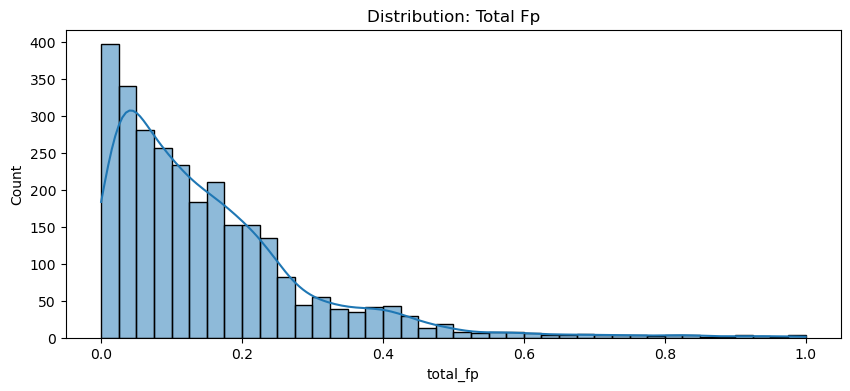

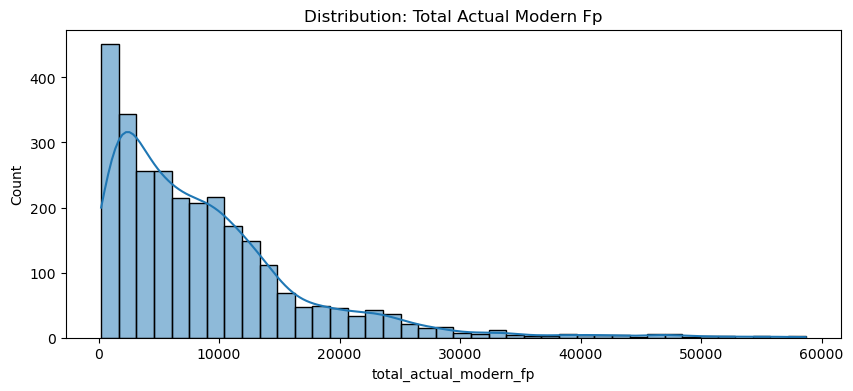

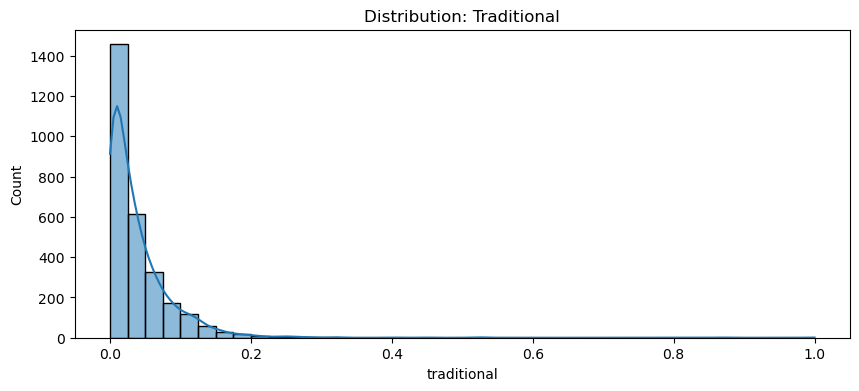

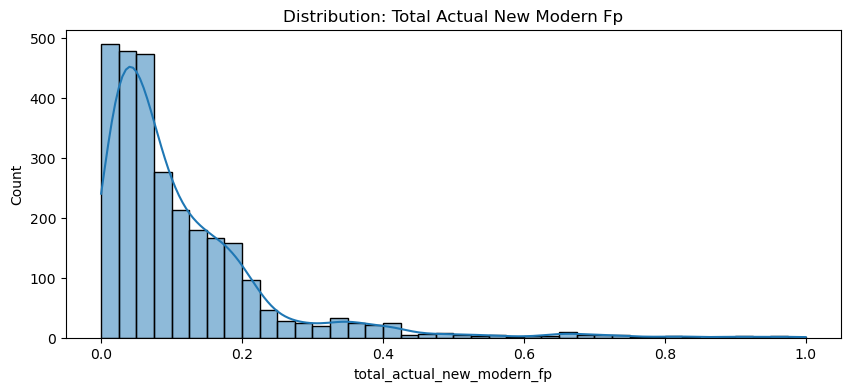

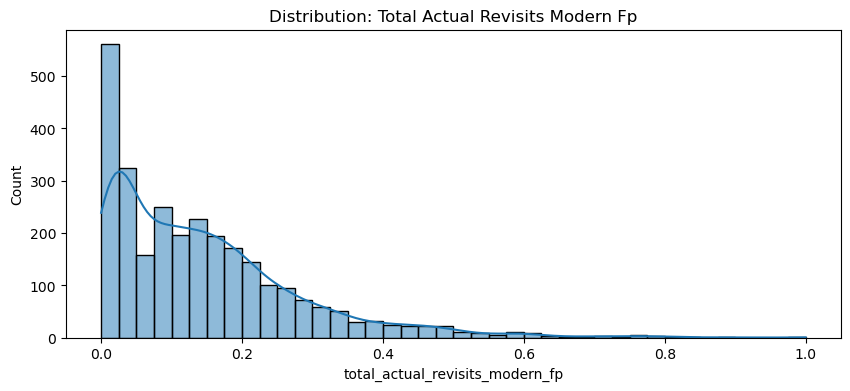

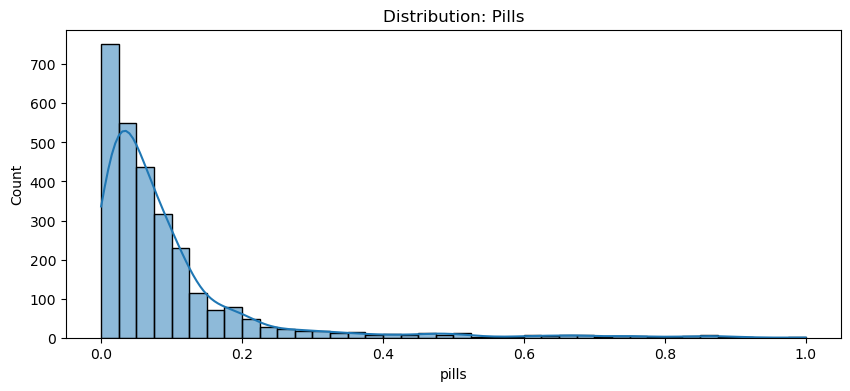

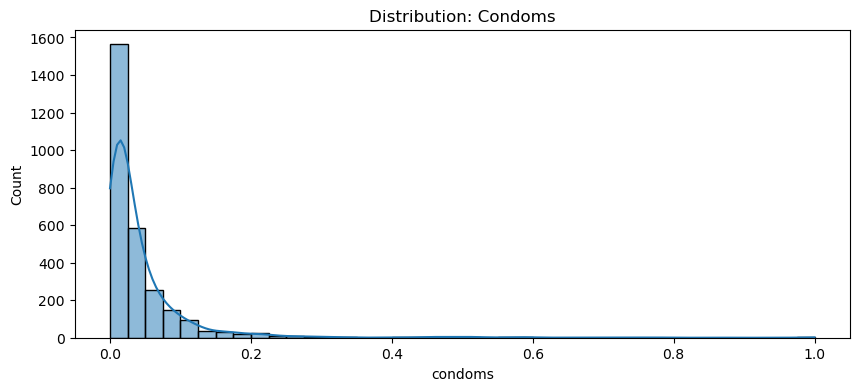

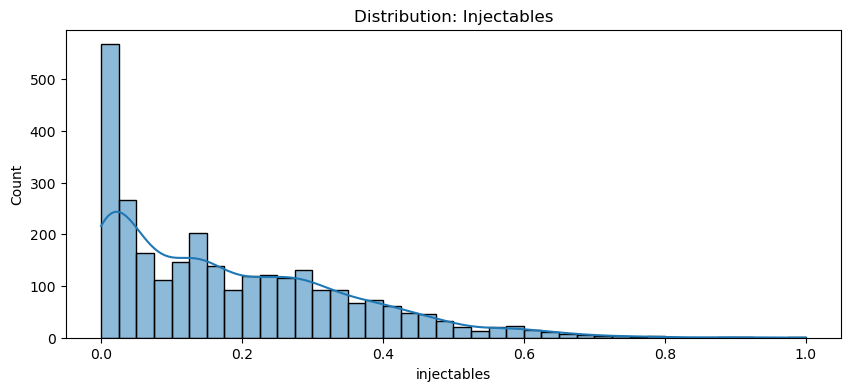

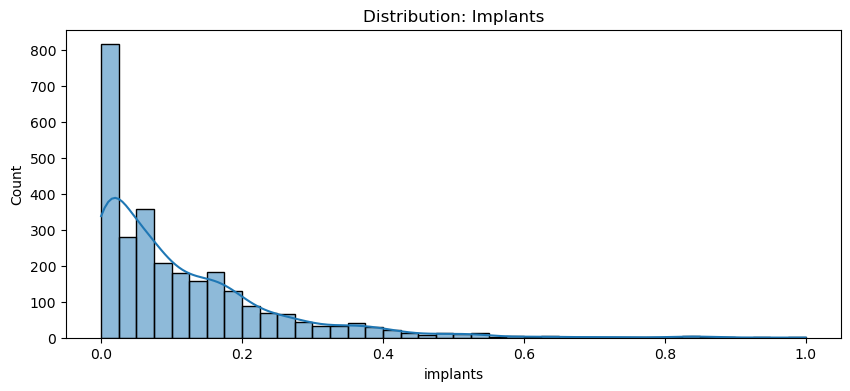

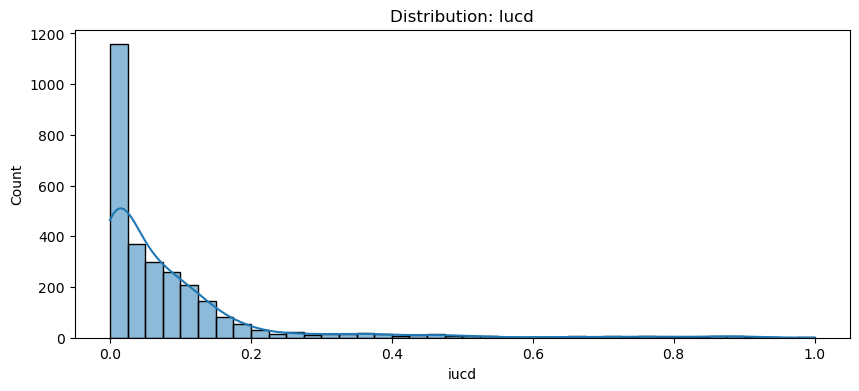

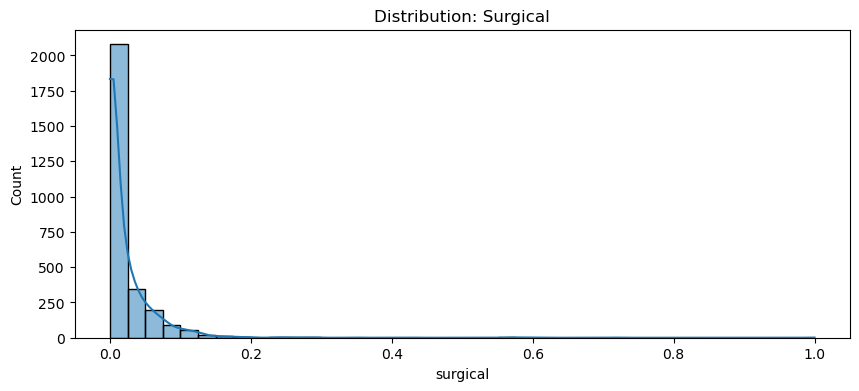

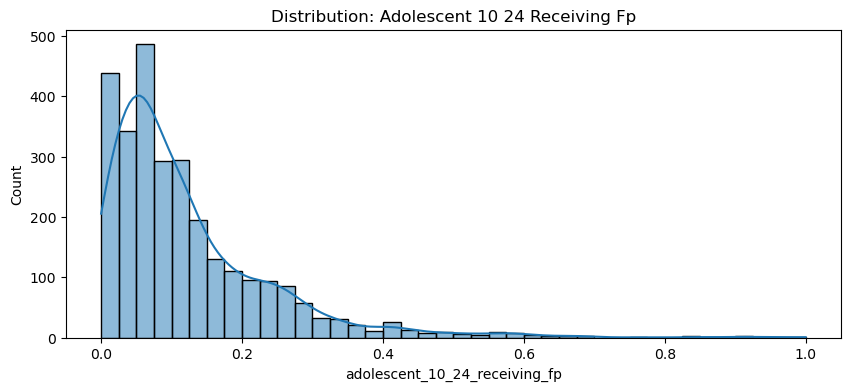

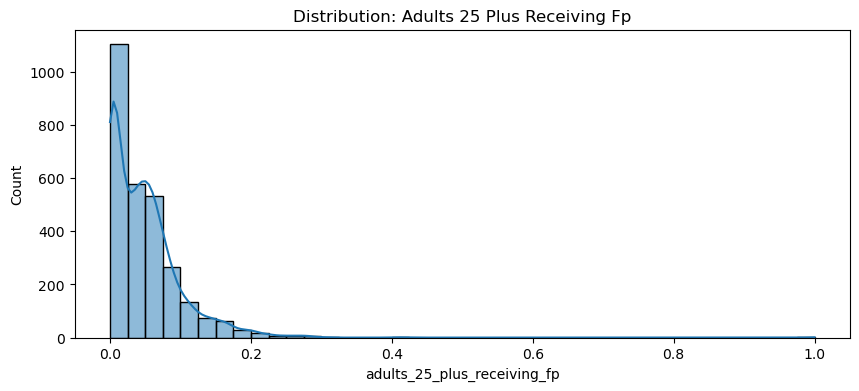

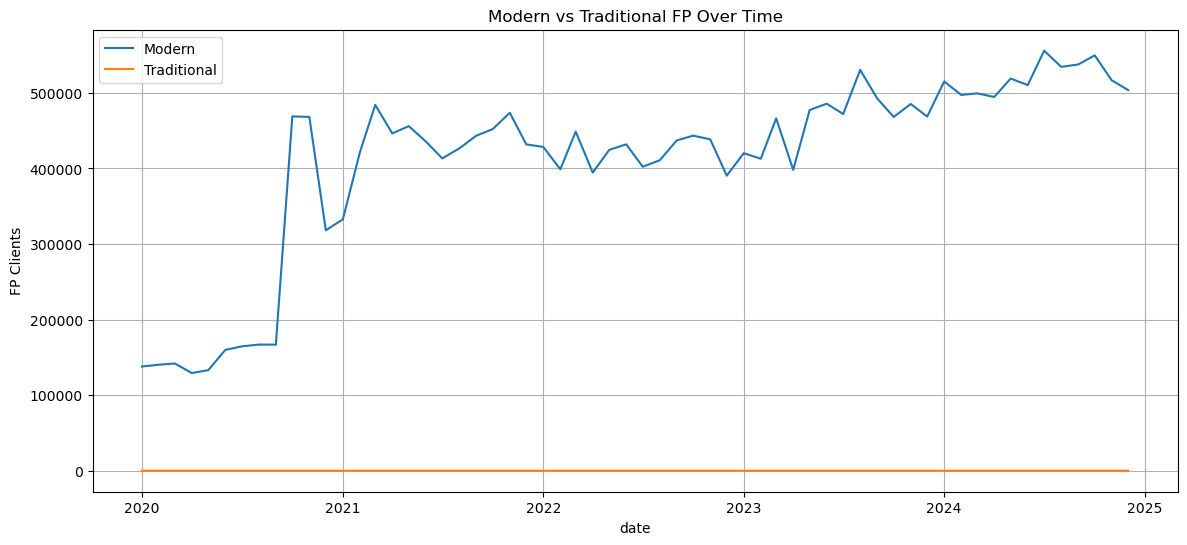

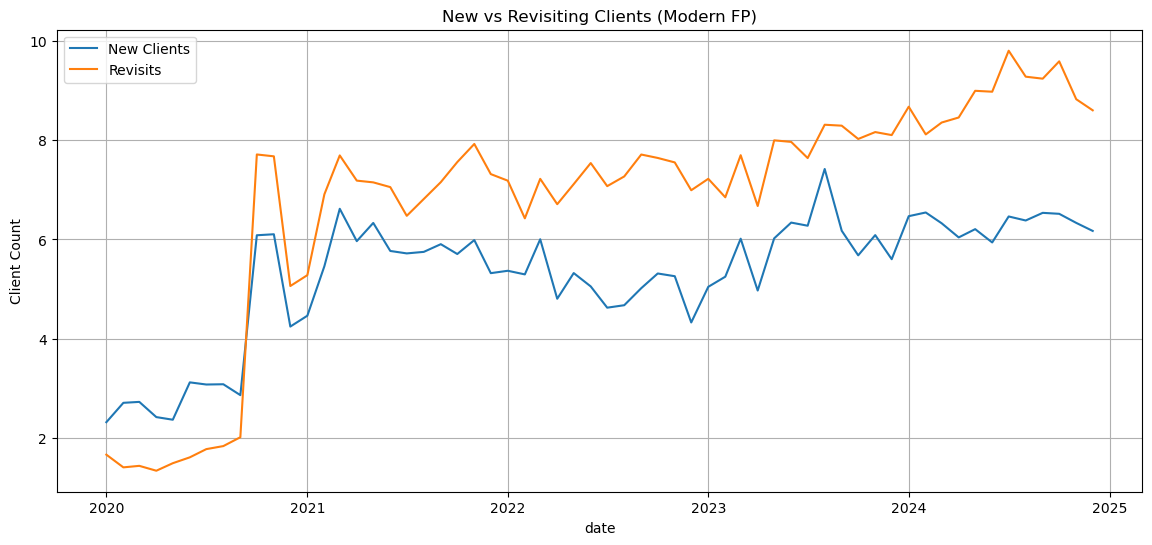

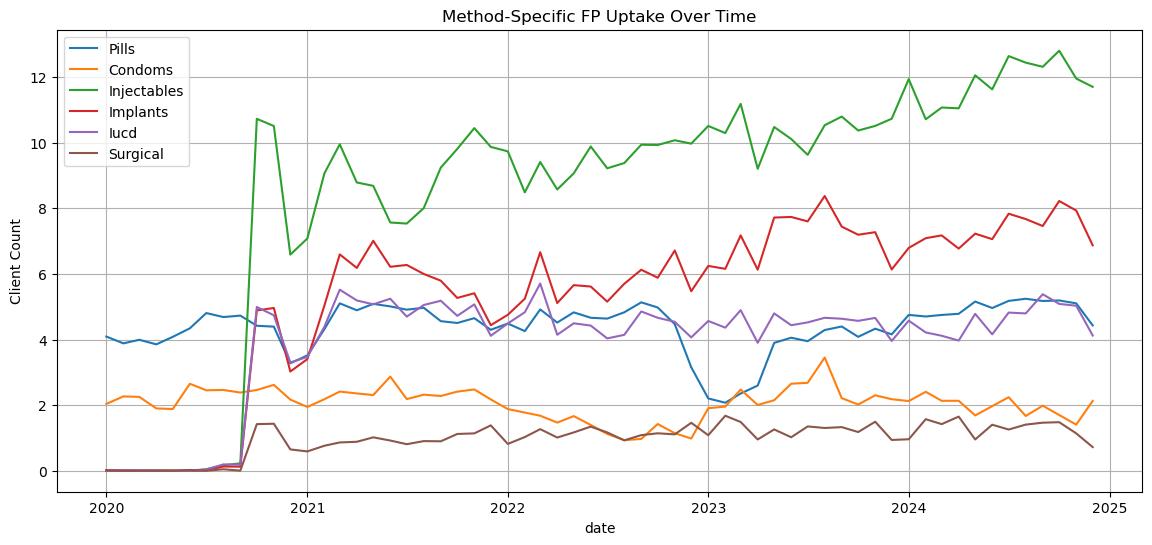

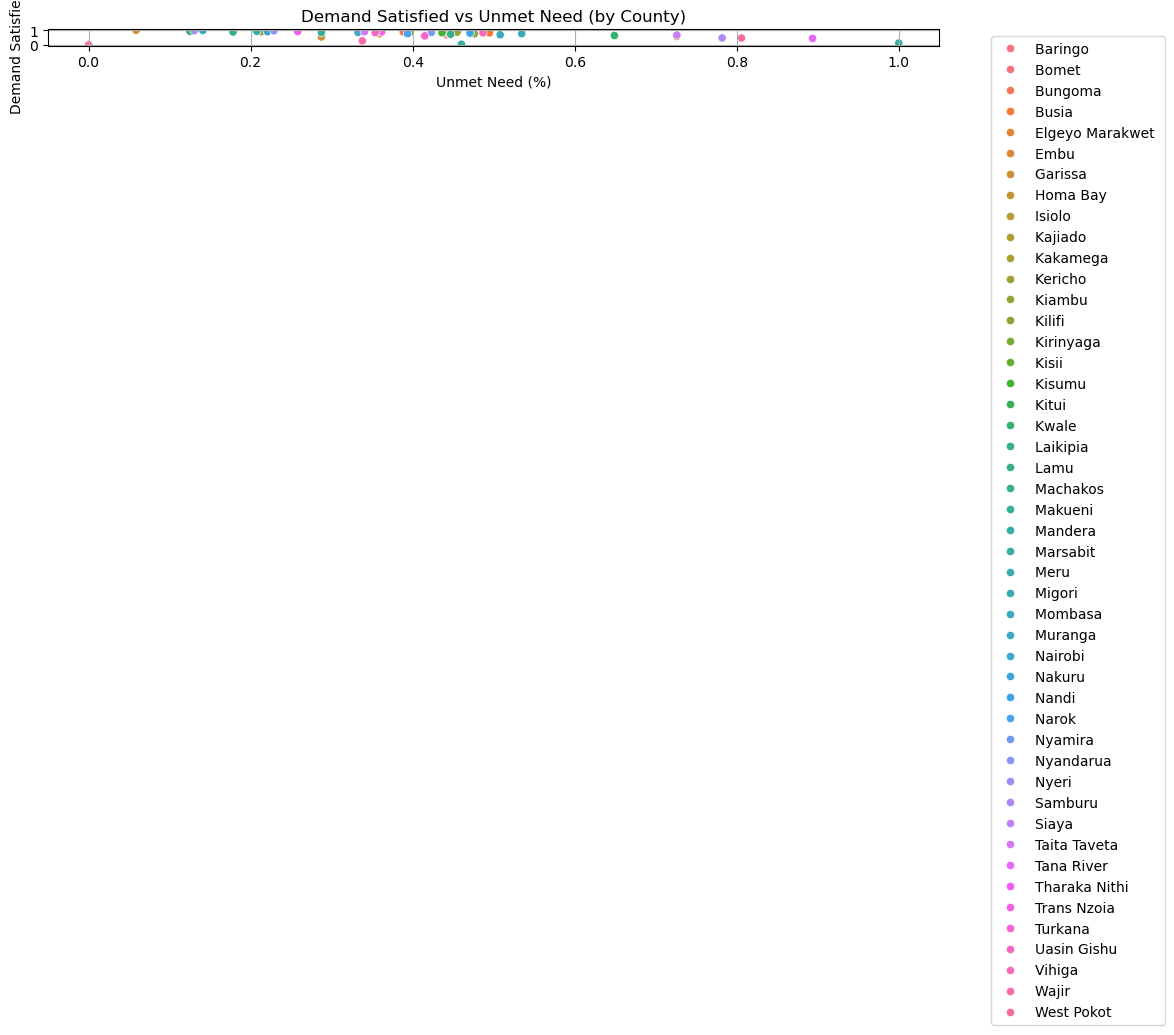

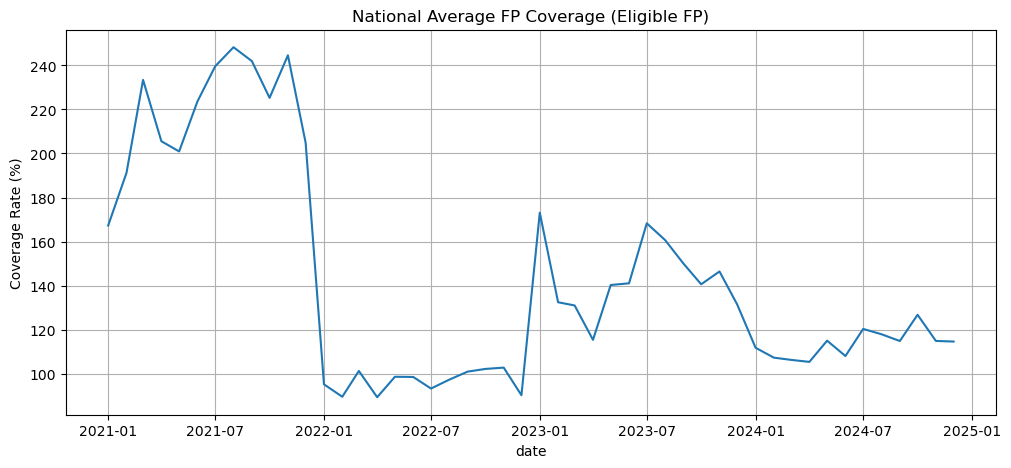

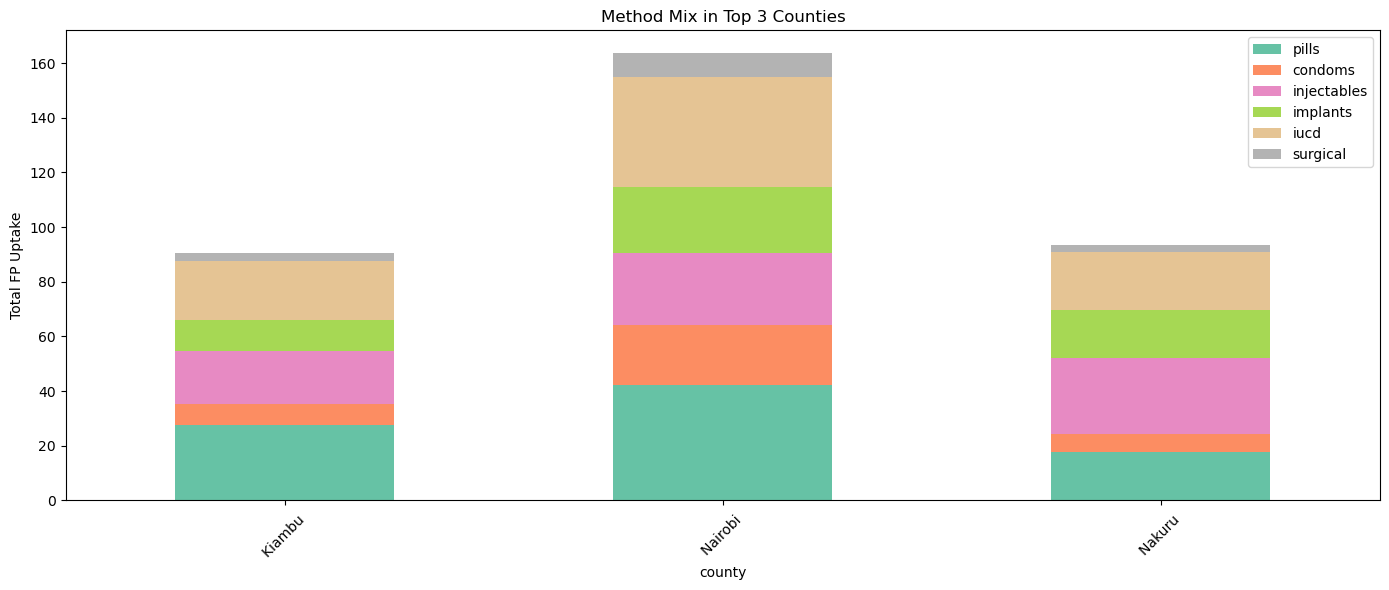

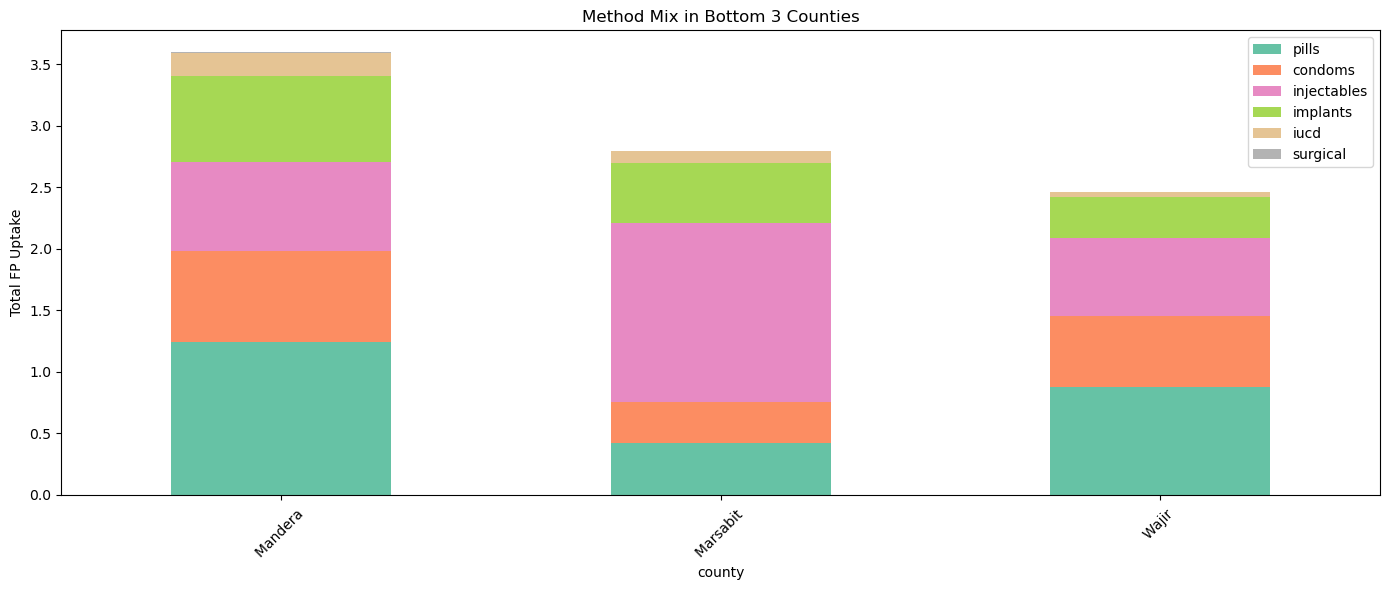

In [75]:
print("\n--- Advanced Exploratory Data Analysis (EDA) ---")
print("This phase explores FP service delivery trends across Kenya. Focus areas include method mix, new vs revisits, modern vs traditional use, demand satisfaction, and population alignment, disaggregated by year, month, and county.")

# Step 2.1: Load Data
eda_target_cols = [
    'total_fp', 'total_actual_modern_fp', 'traditional',
    'total_actual_new_modern_fp', 'total_actual_revisits_modern_fp',
    'pills', 'condoms', 'injectables', 'implants', 'iucd', 'surgical',
    'adolescent_10_24_receiving_fp', 'adults_25_plus_receiving_fp'
]

key_numerical_features = [
    'eligible_fp',
    'demand_satisfied_by_modern_methods_percent', 'mcpr_married_women_percent',
    'total_unmet_need_married_women_percent', 'total_cyp'
]

# Ensure datetime type
data_df['date'] = pd.to_datetime(data_df['date'], errors='coerce')
data_df['year_month'] = data_df['date'].dt.to_period('M').astype(str)
data_df['year'] = data_df['date'].dt.year

# Step 2.5: Data Overview
print("\n--- Step 2.5: Data Overview ---")
print(data_df.info())
missing_counts = data_df[eda_target_cols + key_numerical_features].isnull().sum()
print("\nMissing Values:\n", missing_counts[missing_counts > 0])

print("\nDescriptive Statistics:\n", data_df[eda_target_cols + key_numerical_features].describe().T)

print("\nUnique Counties:", data_df['county'].nunique())
print("Years:", data_df['year'].unique())
print("Year-Months:", data_df['year_month'].nunique())

# Step 2.6: Distributions
import matplotlib.pyplot as plt
import seaborn as sns

for col in eda_target_cols:
    if col in data_df.columns:
        plt.figure(figsize=(10, 4))
        sns.histplot(data_df[col], kde=True, bins=40)
        plt.title(f'Distribution: {col.replace("_", " ").title()}')
        plt.show()

# Step 2.7: Temporal Trends

# 2.7.1 Modern vs Traditional
fp_trend = data_df.groupby('date')[['total_actual_modern_fp', 'traditional']].sum().reset_index() # Corrected column name
plt.figure(figsize=(14, 6))
sns.lineplot(data=fp_trend, x='date', y='total_actual_modern_fp', label='Modern') # Corrected column name
sns.lineplot(data=fp_trend, x='date', y='traditional', label='Traditional')
plt.title("Modern vs Traditional FP Over Time")
plt.ylabel("FP Clients")
plt.grid(True)
plt.legend()
plt.show()

# 2.7.2 New vs Revisits
new_revisit_trend = data_df.groupby('date')[[
    'total_actual_new_modern_fp', 'total_actual_revisits_modern_fp'
]].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=new_revisit_trend, x='date', y='total_actual_new_modern_fp', label='New Clients')
sns.lineplot(data=new_revisit_trend, x='date', y='total_actual_revisits_modern_fp', label='Revisits')
plt.title("New vs Revisiting Clients (Modern FP)")
plt.ylabel("Client Count")
plt.grid(True)
plt.legend()
plt.show()

# 2.7.3 Method Mix
method_cols = ['pills', 'condoms', 'injectables', 'implants', 'iucd', 'surgical']
method_trend = data_df.groupby('date')[method_cols].sum().reset_index()
plt.figure(figsize=(14, 6))
for col in method_cols:
    sns.lineplot(data=method_trend, x='date', y=col, label=col.title())
plt.title("Method-Specific FP Uptake Over Time")
plt.ylabel("Client Count")
plt.grid(True)
plt.legend()
plt.show()

# 2.7.4 Demand Satisfied vs Unmet Need
demand_gap_df = data_df.groupby(['year_month', 'county'])[
    ['demand_satisfied_by_modern_methods_percent', 'total_unmet_need_married_women_percent']
].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=demand_gap_df,
                x='total_unmet_need_married_women_percent',
                y='demand_satisfied_by_modern_methods_percent',
                hue='county')
plt.title("Demand Satisfied vs Unmet Need (by County)")
plt.xlabel("Unmet Need (%)")
plt.ylabel("Demand Satisfied (%)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2.7.5 Coverage Rate
data_df['fp_coverage_rate'] = data_df['total_fp'] / data_df['eligible_fp'] * 100
coverage_trend = data_df.groupby('date')['fp_coverage_rate'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=coverage_trend, x='date', y='fp_coverage_rate')
plt.title("National Average FP Coverage (Eligible FP)")
plt.ylabel("Coverage Rate (%)")
plt.grid(True)
plt.show()

# Step 2.8: County-Level Method Mix Comparison
top_counties = data_df.groupby('county')['total_fp'].sum().nlargest(3).index.tolist()
bottom_counties = data_df.groupby('county')['total_fp'].sum().nsmallest(3).index.tolist()

def plot_method_mix(counties, title):
    df = data_df[data_df['county'].isin(counties)]
    method_mix = df.groupby('county')[method_cols].sum()
    method_mix.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set2')
    plt.title(title)
    plt.ylabel('Total FP Uptake')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_method_mix(top_counties, "Method Mix in Top 3 Counties")
plot_method_mix(bottom_counties, "Method Mix in Bottom 3 Counties")

# Step 2.9: Correlation Matrix
corr_cols = eda_target_cols + key_numerical_features
corr_df = data_df[corr_cols].copy()
corr_matrix = corr_df.corr()

## Target & Feature definition and Scaling

# 🧹 4. Data Preparation and Advanced Feature Engineering

##
This stage involves transforming raw data into structured sequences suitable for time series modeling with LSTMs.

## 🧰 Key Preprocessing Steps

- **Datetime Standardization**: Unified `year` and `month` fields into a continuous `year_month` feature
- **Missing Value Handling**: Retained `NaN` where important (e.g., ‘Unknown’ categories), used forward-fill for temporal continuity in time series
- **Encoding**: Used `LabelEncoder` for categorical variables like `county`, `method`, and `age group`
- **Scaling**: Applied `MinMaxScaler` to numerical features for neural network stability
- **Sequence Construction**: Transformed data into 3D shape `[samples, timesteps, features]` for LSTM compatibility

## 🧮 Output

Cleaned and transformed data ready for model training, with consistent temporal alignment across inputs and targets.

---

In [ ]:
print("\nStep 3.5: Preparing data for modeling.")
print("\nStep 3.5.1: Defining target and feature columns for modeling.")

# Define target columns
target_cols = [
    'total_fp',
    'total_users_receiving_fp',
    'total_actual_new_modern_fp',
    'total_actual_revisits_modern_fp',
    'total_actual_traditional_methods',
    'adolescent_10_24_receiving_fp',
    'adults_25_plus_receiving_fp'
]

# Define feature columns
numerical_col = [
    'year_month',
    'year',
    'periodid',
    'pills_combined_oral_contraceptive_stock_losses',
    'pills_combined_oral_contraceptive_stock_requested',
    'pills_emergency_pill_stock_losses',
    'pills_emergency_pill_stock_requested',
    'pills_progestin_only_pills_stock_losses',
    'pills_progestin_only_pills_stock_requested',
    'condoms_female_condom_stock_losses',
    'condoms_female_condom_stock_requested',
    'condoms_male_condom_stock_losses',
    'condoms_male_condom_stock_requested',
    'injectables_stock_losses',
    'injectables_stock_requested',
    'implants_stock_losses',
    'implants_stock_requested',
    'iud_stock_losses',
    'iud_stock_requested',
    'women_of_childbearing_age_15_49yrs',
    'eligible_fp',
    'demand_satisfied_by_modern_methods_percent',
    'mcpr_married_women_percent',
    'total_unmet_need_married_women_percent',
    'adolescent_10_24_receiving_fp_new',
    'adolescent_10_24_receiving_fp_revisits',
    'adults_25_plus_receiving_fp_services_new',
    'adults_25_plus_receiving_fp_services_revisits',
    'condoms_new',
    'condoms_revisits',
    'pills_new',
    'pills_revisits',
    'injectable_new',
    'injectable_revisits',
    'implants_new',
    'implants_revisits',
    'iucd_new',
    'iucd_revisits',
    'surgical_new',
    'surgical_revisits',
    'traditional_new',
    'traditional_revisits',
    'adolescent_10_24_receiving_fp',
    'adults_25_plus_receiving_fp',
    'condoms',
    'pills',
    'injectables',
    'implants',
    'iucd',
    'surgical',
    'traditional',
    'total_modern_fp',
    'total_cyp',
    'total_users_receiving_fp',
    'total_actual_new_modern_fp',
    'total_actual_revisits_modern_fp',
    'total_actual_traditional_methods'
]

# Ensure numerical columns exist in the DataFrame
numerical_col = [col for col in numerical_col if col in data_df.columns]

# Convert numerical columns to numeric types, coercing errors to NaN
for col in numerical_col:
    data_df[col] = pd.to_numeric(data_df[col], errors='coerce')
data_df = data_df.fillna(0)  # Fill NaNs created by coercion with 0

categorical_cols = ['county', 'periodname']
features_cols = numerical_col + categorical_cols

# Time and ID columns
time_col = 'year_month'

print("\nStep 3.5.2: Scaling and Encoding.")

# Encode categorical features
le = LabelEncoder()
data_df['county_encoded'] = le.fit_transform(data_df['county'])
data_df['periodname'] = data_df['periodname'].astype('category').cat.codes

# Define the final feature columns
numerical_features = numerical_col
categorical_features = ['county_encoded', 'periodname']
model_input_features_names = numerical_features + categorical_features

# --- Step 3.5.3: Scaling Numerical Features ---
available_numerical_cols = [col for col in numerical_features if col in data_df.columns]
if not available_numerical_cols:
    raise ValueError("No valid numerical columns found to scale.")

scaler = MinMaxScaler()
data_df[available_numerical_cols] = scaler.fit_transform(data_df[available_numerical_cols])
feature_scaler = scaler 

# --- Normalize target columns ---
print("\nStep 3.5.4: Scaling target columns using MinMaxScaler.")
available_target_cols = [col for col in target_cols if col in data_df.columns]
if not available_target_cols:
    raise ValueError("No valid target columns found to scale.")
target_scaler = MinMaxScaler()
data_df[available_target_cols] = target_scaler.fit_transform(data_df[available_target_cols])

# Prepare the target DataFrame for sequences
y_for_sequences = data_df[available_target_cols].copy()

# Ensure the target DataFrame has the same index as the features DataFrame
print("\nStep 3.5.5: Splitting data into train, validation, and test sets by county and time")
SEQUENCE_LENGTH = 12
unique_counties = data_df['county_encoded'].unique()
train_data_list, val_data_list, test_data_list = [], [], []

for county in unique_counties:
    county_df = data_df[data_df['county_encoded'] == county].sort_values(time_col)
    n = len(county_df)
    n_train, n_val = int(0.8 * n), int(0.1 * n)
    train_data_list.append(county_df.iloc[:n_train])
    val_data_list.append(county_df.iloc[n_train:n_train + n_val])
    test_data_list.append(county_df.iloc[n_train + n_val:])

train_df = pd.concat(train_data_list).reset_index(drop=True)
val_df = pd.concat(val_data_list).reset_index(drop=True)
test_df = pd.concat(test_data_list).reset_index(drop=True)

# --- Step 3.5.6: Create Sequences for Time-Series Modeling ---
print("\nStep 3.5.6: Creating sequences for time-series modeling.")
def create_sequences(features_df, targets_df, sequence_length, county_col='county_encoded', model_features_list=None):
    X_seq_features, X_seq_county, y_seq = [], [], []
    for county in features_df[county_col].unique():
        f_df = features_df[features_df[county_col] == county].sort_values(time_col).reset_index(drop=True)
        t_df = targets_df[targets_df.index.isin(f_df.index)].reindex(f_df.index).reset_index(drop=True)

        county_encoded_val = f_df[county_col].iloc[0]
        features_only = f_df[model_features_list].copy()
        targets_only = t_df[[col for col in targets_df.columns if col not in ['county', time_col]]]

        if len(features_only) < sequence_length + 1:
            continue

        for i in range(len(features_only) - sequence_length):
            X_seq_features.append(features_only.iloc[i:i + sequence_length].values.astype(np.float32))
            X_seq_county.append(county_encoded_val)
            y_seq.append(targets_only.iloc[i + sequence_length].values.astype(np.float32))

    return (
        np.array(X_seq_features),
        np.array(X_seq_county, dtype=np.int32),
        np.array(y_seq)
    )

# --- Step 3.5.7: Generate Sequences ---
X_train_features, X_train_county, y_train_seq = create_sequences(
    train_df,
    y_for_sequences,
    SEQUENCE_LENGTH,
    model_features_list=model_input_features_names
)
X_val_features, X_val_county, y_val_seq = create_sequences(
    val_df,
    y_for_sequences,
    SEQUENCE_LENGTH,
    model_features_list=model_input_features_names
)
X_test_features, X_test_county, y_test_seq = create_sequences(
    test_df,
    y_for_sequences,
    SEQUENCE_LENGTH,
    model_features_list=model_input_features_names
)

# --- Step 3.5.8: Store Prepared Data and Metadata ---
print("\nStep 3.5.8: Storing all prepared data and metadata in a dictionary")
data_dict = {
    'X_train_features': X_train_features,
    'X_train_county': X_train_county,
    'y_train': y_train_seq,
    'X_val_features': X_val_features,
    'X_val_county': X_val_county,
    'y_val': y_val_seq,
    'X_test_features': X_test_features,
    'X_test_county': X_test_county,
    'y_test': y_test_seq,
    'target_cols': available_target_cols,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'model_input_features_names': model_input_features_names,
    'SEQUENCE_LENGTH': SEQUENCE_LENGTH,
    'county_encoder': le,
    'feature_scaler': feature_scaler,
    'target_scaler': target_scaler,
    'full_data_df': data_df
}

print("\n✅ Data Preparation Complete")
print(f"Final processed data shape: {data_df.shape}")
print(f"Train Features Shape: {X_train_features.shape}, Train Targets Shape: {y_train_seq.shape}")
print(f"Validation Features Shape: {X_val_features.shape}, Test Features Shape: {X_test_features.shape}")
print(f"Unique counties: {len(data_dict['county_encoder'].classes_)}")
print(f"Sequence feature count per step: {X_train_features.shape[2]}")


Step 3.5: Preparing data for modeling.

Step 3.5.1: Defining target and feature columns for modeling.

Step 3.5.2: Scaling and Encoding.

Step 3.5.4: Scaling target columns using MinMaxScaler.

Step 3.5.5: Splitting data into train, validation, and test sets by county and time

Step 3.5.6: Creating sequences for time-series modeling.

Step 3.5.8: Storing all prepared data and metadata in a dictionary

✅ Data Preparation Complete
Final processed data shape: (2820, 172)
Train Features Shape: (1692, 12, 59), Train Targets Shape: (1692, 7)
Validation Features Shape: (0,), Test Features Shape: (0,)
Unique counties: 47
Sequence feature count per step: 59


In [ ]:


# Global variable to hold the full processed DataFrame
full_data_df = None

def get_variable_mappings():
    """
    Returns a dictionary of target variables, a list of predictors (safe), and a mapping dict
    for use in Streamlit apps and modeling pipelines.
    """
    
    # Define target variables that are used in the model
    target_variables = [
        'total_fp',
        'total_users_receiving_fp',
        'total_actual_new_modern_fp',
        'total_actual_revisits_modern_fp',
        'total_actual_traditional_methods',
        'adolescent_10_24_receiving_fp',
        'adults_25_plus_receiving_fp'
    ]
    
    # Define all possible columns that could be used as predictors
    all_possible_columns = [
        'condoms_new', 'condoms_revisits',
        'pills_new', 'pills_revisits',
        'injectable_new', 'injectable_revisits',
        'implants_new', 'implants_revisits',
        'iucd_new', 'iucd_revisits',
        'surgical_new', 'surgical_revisits',
        'traditional_new', 'traditional_revisits',
        'adolescent_10_24_receiving_fp',
        'adults_25_plus_receiving_fp',
        'condoms', 'pills', 'injectables', 'implants', 'iucd', 'surgical', 'traditional',
        'total_modern_fp', 'total_cyp',
        'total_actual_new_modern_fp', 'total_actual_revisits_modern_fp', 'total_actual_traditional_methods',
        'pills_combined_oral_contraceptive_stock_losses',
        'pills_combined_oral_contraceptive_stock_requested',
        'pills_emergency_pill_stock_losses',
        'pills_emergency_pill_stock_requested',
        'pills_progestin_only_pills_stock_losses',
        'pills_progestin_only_pills_stock_requested',
        'condoms_female_condom_stock_losses',
        'condoms_female_condom_stock_requested',
        'condoms_male_condom_stock_losses',
        'condoms_male_condom_stock_requested',
        'injectables_stock_losses',
        'injectables_stock_requested',
        'implants_stock_losses',
        'implants_stock_requested',
        'iud_stock_losses',
        'iud_stock_requested',
        'adolescent_10_24_receiving_fp_new',
        'adolescent_10_24_receiving_fp_revisits',
        'adults_25_plus_receiving_fp_services_new',
        'adults_25_plus_receiving_fp_services_revisits'
    ]

    # Filter out target variables from all possible columns to get predictor variables
    predictor_variables = [col for col in all_possible_columns if col not in target_variables]

    # Create a mapping of target variables to themselves (identity mapping)
    target_variable_mapping = {var: var for var in target_variables}

    return target_variables, predictor_variables, target_variable_mapping



In [ ]:
# Step 3.5: Prepare data for modeling
print("\nStep 3.5: Preparing data for modeling.")
target_cols, numerical_features, target_variable_mapping = get_variable_mappings()
categorical_features = ['county_encoded', 'periodname']
model_input_features_names = numerical_features + categorical_features


In [70]:
for col, dtype in data_df.dtypes.items():
    print(f"{col}: {dtype}")



year_month: float64
country: object
county: object
uid: object
county_code: object
estimated_number_of_pregnant_women: float64
fp_injections_dmpa_im_new_clients: float64
fp_injections_dmpa_im_re_visits: float64
fp_injections_dmpa_sc_new_clients: float64
fp_injections_dmpa_sc_re_visits: float64
year: float64
uid_code: object
uidear: object
periodid: float64
periodname: int8
organisationunitname: object
pills_combined_oral_contraceptive_stock_losses: float64
pills_combined_oral_contraceptive_stock_dispensed: float64
pills_combined_oral_contraceptive_stock_at_hand: float64
pills_combined_oral_contraceptive_stock_requested: float64
pills_combined_oral_contraceptive_stock_received: float64
pills_emergency_pill_stock_losses: float64
pills_emergency_pill_stock_dispensed: float64
pills_emergency_pill_stock_at_hand: float64
pills_emergency_pill_stock_requested: float64
pills_emergency_pill_stock_received: float64
pills_progestin_only_pills_stock_losses: float64
pills_progestin_only_pills_stock_

##

##

# 🤖 5. Modeling

This stage involves training deep learning models to forecast FP demand by method, county, and demographic.

## 🏗️ Model Architecture

- **Model Type**: LSTM-based multivariate sequence-to-sequence model
- **Input Features**: Population, method use, revisits, new clients, stock levels, age group proportions
- **Output Targets**: FP demand metrics such as total clients, method-specific use, and adolescent uptake

### 📌 Key Components

- `Input` → `LSTM` → `Dense` layers with dropout
- EarlyStopping and ReduceLROnPlateau callbacks
- Custom loss: `MeanSquaredError`

## ⚙️ Training Strategy

- **Validation**: Used `TimeSeriesSplit` to preserve temporal order
- **Loss Function**: MSE
- **Evaluation Metrics**:
  - MAE (Mean Absolute Error)
  - RMSE (Root Mean Squared Error)
  - MAPE (Mean Absolute Percentage Error)
- **Tools Used**: `TensorFlow`, `Keras`, `scikit-learn`, `joblib`

---

## Split_test_train

In [ ]:

print("\nStep 3.5.1: Defining target and feature columns based on modeling goals.")
data_df = data_df.loc[:, ~data_df.columns.duplicated()]

# --- Targets: predicting FP demand and related implications ---
target_cols = [
    'total_users_receiving_fp',
    'total_actual_new_modern_fp',
    'total_actual_revisits_modern_fp',
    'adolescent_10_24_receiving_fp',
    'adults_25_plus_receiving_fp',
    'total_actual_traditional_methods',
    'total_cyp'
]

# --- Numerical Features ---
numerical_cols = [
    'women_of_childbearing_age_15_49yrs',
    'eligible_fp',
    'demand_satisfied_by_modern_methods_percent',
    'mcpr_married_women_percent',
    'total_unmet_need_married_women_percent',

    # Stock levels
    'pills_combined_oral_contraceptive_stock_at_hand',
    'pills_emergency_pill_stock_at_hand',
    'pills_progestin_only_pills_stock_at_hand',
    'condoms_female_condom_stock_at_hand',
    'condoms_male_condom_stock_at_hand',
    'injectables_stock_at_hand',
    'implants_stock_at_hand',
    'iud_stock_at_hand',

    # Stock movement metrics
    'pills_combined_oral_contraceptive_stock_losses',
    'injectables_stock_losses',
    'implants_stock_losses',
    'iud_stock_losses',
    'pills_combined_oral_contraceptive_stock_requested',
    'injectables_stock_requested',
    'implants_stock_requested',
    'iud_stock_requested',
    'condoms_new',
    'condoms_revisits',
    'pills_new',
    'pills_revisits',
    'injectable_new',
    'injectable_revisits',
    'implants_new',
    'implants_revisits',
    'iucd_new',
    'iucd_revisits',
    'surgical_new',
    'surgical_revisits',
    'traditional_new',
    'traditional_revisits',
    'condoms',
    'pills',
    'injectables',
    'implants',
    'iucd',
    'surgical'
]

# Filter to retain only columns that exist
numerical_cols = [col for col in numerical_cols if col in data_df.columns]
target_cols = [col for col in target_cols if col in data_df.columns]

# --- Categorical Features ---
categorical_cols = ['county', 'country']
categorical_cols = [col for col in categorical_cols if col in data_df.columns]

# --- Time & ID columns ---
time_col = 'year_month'
id_cols = ['uid', 'year', 'county_code', 'uid_code', 'uidear', 'periodid', 'periodname', 'organisationunitname']
id_cols = [col for col in id_cols if col in data_df.columns]

feature_cols = numerical_cols + categorical_cols

print("\nStep 3.5.2: Encoding categorical features and scaling numerical ones.")

# Encode categorical features
for col in categorical_cols:
    data_df[col] = LabelEncoder().fit_transform(data_df[col].astype(str))

# Scale numerical features
scaler = MinMaxScaler()
data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])

# Scale targets
target_scaler = MinMaxScaler()
data_df[target_cols] = target_scaler.fit_transform(data_df[target_cols])
data_dict['target_scaler'] = target_scaler

print("\nStep 3.5.3: Creating sequences for time-series modeling.")

sequence_length = 6
X_county, X_features, y_targets = [], [], []
unique_units = data_df['county'].unique()

for county in unique_units:
    county_df = data_df[data_df['county'] == county].sort_values(by=time_col)
    for i in range(len(county_df) - sequence_length):
        seq_slice = county_df.iloc[i:i + sequence_length]
        X_county.append(seq_slice['county'].values[-1])
        X_features.append(seq_slice[feature_cols].values)
        y_targets.append(county_df[target_cols].iloc[i + sequence_length].values)

X_county = np.array(X_county)
X_features = np.array(X_features)
y_targets = np.array(y_targets)

print("\nStep 3.5.4: Splitting into train, validation, and test sets.")

X_county_train, X_county_temp, X_features_train, X_features_temp, y_train, y_temp = train_test_split(
    X_county, X_features, y_targets, test_size=0.2, random_state=42
)
X_county_val, X_county_test, X_features_val, X_features_test, y_val, y_test = train_test_split(
    X_county_temp, X_features_temp, y_temp, test_size=0.5, random_state=42
)

data_dict = {
    'X_county_train': X_county_train,
    'X_features_train': X_features_train,
    'y_train': y_train,
    'X_county_val': X_county_val,
    'X_features_val': X_features_val,
    'y_val': y_val,
    'X_county_test': X_county_test,
    'X_features_test': X_features_test,
    'y_test': y_test,
    'target_cols': target_cols,
    'feature_cols': feature_cols,
    'target_scaler': target_scaler 
}


print("\nData dictionary ready. Keys available:", list(data_dict.keys()))

#--- Data Prepared and Modeling-Ready ---

print("\n✅ Step 4.0 Complete: Data is prepared and modeling inputs are ready.")
print("X_features shape:", X_features.shape)
print("y_targets shape:", y_targets.shape)
print("Training samples:", len(X_features_train))
print("Validation samples:", len(X_features_val))
print("Test samples:", len(X_features_test))

print("\n🔜 Next Step: Proceed to CRISP-DM 5.0 — Model Building (e.g., LSTM, GRU, RandomForest, etc.)")




Step 3.5.1: Defining target and feature columns based on modeling goals.

Step 3.5.2: Encoding categorical features and scaling numerical ones.

Step 3.5.3: Creating sequences for time-series modeling.

Step 3.5.4: Splitting into train, validation, and test sets.

Data dictionary ready. Keys available: ['X_county_train', 'X_features_train', 'y_train', 'X_county_val', 'X_features_val', 'y_val', 'X_county_test', 'X_features_test', 'y_test', 'target_cols', 'feature_cols', 'target_scaler']

✅ Step 4.0 Complete: Data is prepared and modeling inputs are ready.
X_features shape: (2538, 6, 43)
y_targets shape: (2538, 7)
Training samples: 2030
Validation samples: 254
Test samples: 254

🔜 Next Step: Proceed to CRISP-DM 5.0 — Model Building (e.g., LSTM, GRU, RandomForest, etc.)


In [ ]:
data_dict['target_scaler'] = target_scaler

In [ ]:
data_df.columns.tolist()


['year_month',
 'country',
 'county',
 'uid',
 'county_code',
 'estimated_number_of_pregnant_women',
 'fp_injections_dmpa_im_new_clients',
 'fp_injections_dmpa_im_re_visits',
 'fp_injections_dmpa_sc_new_clients',
 'fp_injections_dmpa_sc_re_visits',
 'year',
 'uid_code',
 'uidear',
 'periodid',
 'periodname',
 'organisationunitname',
 'pills_combined_oral_contraceptive_stock_losses',
 'pills_combined_oral_contraceptive_stock_dispensed',
 'pills_combined_oral_contraceptive_stock_at_hand',
 'pills_combined_oral_contraceptive_stock_requested',
 'pills_combined_oral_contraceptive_stock_received',
 'pills_emergency_pill_stock_losses',
 'pills_emergency_pill_stock_dispensed',
 'pills_emergency_pill_stock_at_hand',
 'pills_emergency_pill_stock_requested',
 'pills_emergency_pill_stock_received',
 'pills_progestin_only_pills_stock_losses',
 'pills_progestin_only_pills_stock_dispensed',
 'pills_progestin_only_pills_stock_at_hand',
 'pills_progestin_only_pills_stock_requested',
 'pills_progestin_o

In [ ]:
print("\n📊 Target Data Summary")
print(f"  🧷 Shape of y_train: {data_dict['y_train'].shape}")
print(f"  🎯 Number of Target Variables: {data_dict['y_train'].shape[1]}")
print(f"  🏷️ Target Columns: {', '.join(data_dict['target_cols'])}")



📊 Target Data Summary
  🧷 Shape of y_train: (2030, 7)
  🎯 Number of Target Variables: 7
  🏷️ Target Columns: total_users_receiving_fp, total_actual_new_modern_fp, total_actual_revisits_modern_fp, adolescent_10_24_receiving_fp, adults_25_plus_receiving_fp, total_actual_traditional_methods, total_cyp


In [ ]:
# --- ✅ Step: Validate and Extract Target Columns ---

# Step 1: Identify present and missing target columns
present_targets = [col for col in target_cols if col in data_df.columns]
missing_targets = [col for col in target_cols if col not in data_df.columns]

# Step 2: Print diagnostic summary
print("\n📋 Target Column Validation")
print(f"  ✅ Present Target Columns ({len(present_targets)}): {', '.join(present_targets)}")
print(f"  ❌ Missing Target Columns ({len(missing_targets)}): {', '.join(missing_targets) if missing_targets else 'None'}")

# Step 3: Define y_train using only valid targets
y_train = data_df[present_targets].copy()
print(f"\n📦 Extracted y_train with shape: {y_train.shape}")

# Step 4 (Optional): Update target_cols to only valid ones
target_cols = present_targets




📋 Target Column Validation
  ✅ Present Target Columns (7): total_users_receiving_fp, total_actual_new_modern_fp, total_actual_revisits_modern_fp, adolescent_10_24_receiving_fp, adults_25_plus_receiving_fp, total_actual_traditional_methods, total_cyp
  ❌ Missing Target Columns (0): None

📦 Extracted y_train with shape: (2820, 7)


## Training models

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Bidirectional
from tensorflow.keras.optimizers import Adam

# ========== SHARED INPUT SHAPE ==========
input_shape = (data_dict['X_features_train'].shape[1], data_dict['X_features_train'].shape[2])
output_dim = len(data_dict['target_cols'])

# ========== 1. BASIC LSTM MODEL ==========
print("🛠️ Building Basic LSTM Model...")
basic_model = Sequential([
    LSTM(64, input_shape=input_shape),
    Dense(output_dim)
])

basic_model.compile(optimizer='adam', loss='mse')

print("🚂 Training Basic LSTM Model...")
basic_model.fit(
    data_dict['X_features_train'], data_dict['y_train'],
    epochs=10,
    batch_size=32,
    validation_data=(data_dict['X_features_val'], data_dict['y_val']),
    verbose=1
)

# ========== 2. ADVANCED LSTM + ATTENTION MODEL ==========
print("\n🛠️ Building Advanced LSTM + Attention Model...")

input_seq = Input(shape=input_shape)

# Encoder: Bidirectional LSTM
x = Bidirectional(LSTM(64, return_sequences=True))(input_seq)
x = Dropout(0.2)(x)

# Multi-Head Attention Block
attention_out = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention_out = Add()([x, attention_out])
attention_out = LayerNormalization()(attention_out)

# Decoder: LSTM + Dropout
x = LSTM(64)(attention_out)
x = Dropout(0.2)(x)

# Output layer
output = Dense(output_dim)(x)

advanced_model = Model(inputs=input_seq, outputs=output)
advanced_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("🚂 Training Advanced LSTM + Attention Model...")
advanced_model.fit(
    data_dict['X_features_train'], data_dict['y_train'],
    epochs=10,
    batch_size=32,
    validation_data=(data_dict['X_features_val'], data_dict['y_val']),
    verbose=1
)

# ========== 3. EVALUATION ==========
print("\n📊 Evaluating Both Models...")
basic_results = evaluate_model_performance(basic_model, data_dict, model_name="Basic LSTM Model")
advanced_results = evaluate_model_performance(advanced_model, data_dict, model_name="Advanced LSTM-Attention Model")




🛠️ Building Basic LSTM Model...
🚂 Training Basic LSTM Model...
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1097 - val_loss: 0.0084
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0024

🛠️ Building Advanced LSTM + Attention Model...
🚂 Training Advanced LSTM + Attention Model...
E

## Extracting and saving artifacts (pkl and dict)

In [ ]:
import os
import joblib

# ========== 4. EXPORT TRAINED ARTIFACTS ==========
print("\n💾 Saving Trained Models and Data Dictionary...")

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save both models
basic_model_path = os.path.join("models", "fp_lstm_basic_model.h5")
advanced_model_path = os.path.join("models", "fp_lstm_model.h5")  # this is the default one used in app

basic_model.save(basic_model_path)
advanced_model.save(advanced_model_path)

# Save the data dictionary (used for preprocessing and inference)
data_dict_path = os.path.join("models", "fp_project_data_dict.pkl")
joblib.dump(data_dict, data_dict_path)

print(f"✅ Models and data_dict saved successfully to 'models/' directory.")



💾 Saving Trained Models and Data Dictionary...
✅ Models and data_dict saved successfully to 'models/' directory.


# 📊 6. Evaluation

The trained model was assessed on a holdout test set and evaluated for generalization, stability, and scale-aware accuracy.

## 📉 Results Summary

| Metric | Purpose | Desired Outcome |
|--------|---------|-----------------|
| MAE | Raw forecast accuracy | <10% variation per target |
| RMSE | Penalizes large errors | Reduce over- and under-supply risks |
| MAPE | Relative performance across counties and methods | <15% error preferred |

### ✅ Observations

- Model performs best in high-volume counties and for widely used methods (e.g., injectables)
- Accuracy drops for commodities with sparse uptake (e.g., sterilization)
- Adolescent segmentation improved targeting accuracy due to age-aware inputs

## Model Evaluation

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_model_performance(model, data_dict, model_name="Model"):
    """
    Evaluates the trained model's performance using MAE, RMSE, R², and MAPE.
    Handles multi-output targets and inverse scaling for interpretation.
    """
    print(f"\n📈 Evaluating {model_name} on Test Set")

    # Extract inputs and targets
    X_test_features = data_dict['X_features_test']
    y_test_actual = data_dict['y_test']
    target_cols = data_dict['target_cols']
    scaler = data_dict['target_scaler']

    # Predict on test set
    y_pred_scaled = model.predict(X_test_features, verbose=0)

    eval_results = {}

    for i, target_col in enumerate(target_cols):
        # Inverse scaling
        min_val = scaler.min_[i]
        scale_val = scaler.scale_[i]
        y_pred = (y_pred_scaled[:, i] * scale_val) + min_val
        y_actual = (y_test_actual[:, i] * scale_val) + min_val

        # Ensure non-negativity and convert to integers if counts
        y_pred = np.maximum(0, y_pred).astype(int)
        y_actual = np.maximum(0, y_actual).astype(int)

        # Evaluation metrics
        mae = mean_absolute_error(y_actual, y_pred)
        rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
        r2 = r2_score(y_actual, y_pred)
        mape = np.mean(np.abs((y_actual - y_pred) / np.where(y_actual != 0, y_actual, 1e-8))) * 100

        # Store metrics
        eval_results[target_col] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape
        }

        # Print metrics per target
        print(f"\n📌 Metrics for target: {target_col}")
        print(f"   📉 MAE:  {mae:.2f}")
        print(f"   📊 RMSE: {rmse:.2f}")
        print(f"   🧪 R²:    {r2:.2f}")
        print(f"   🧭 MAPE: {mape:.2f}%")

    print(f"\n🗂 Summary of {model_name} Evaluation:")
    print(pd.DataFrame.from_dict(eval_results, orient='index'))

    return eval_results


# --- Step 5.1: Evaluate All Models ---

print("\n🚦 Initiating Model Evaluation Phase")
basic_results = evaluate_model_performance(basic_model, data_dict, model_name="Basic LSTM Model")
advanced_results = evaluate_model_performance(advanced_model, data_dict, model_name="Advanced LSTM-Transformer Hybrid Model")


# --- Step 5.2: Aggregate and Compare Results ---

def aggregate_metrics(results):
    return {
        'Avg MAE': np.mean([v['MAE'] for v in results.values()]),
        'Avg RMSE': np.mean([v['RMSE'] for v in results.values()]),
        'Avg MAPE': np.mean([v['MAPE'] for v in results.values()])
    }

basic_avg = aggregate_metrics(basic_results)
advanced_avg = aggregate_metrics(advanced_results)

comparison_df = pd.DataFrame({
    'Metric': ['Avg MAE', 'Avg RMSE', 'Avg MAPE'],
    'Basic LSTM Model': [basic_avg['Avg MAE'], basic_avg['Avg RMSE'], basic_avg['Avg MAPE']],
    'Advanced Hybrid Model': [advanced_avg['Avg MAE'], advanced_avg['Avg RMSE'], advanced_avg['Avg MAPE']]
})

print("\n📊 Aggregated Model Comparison:")
print(comparison_df.to_string(index=False))


# --- Step 5.3: Decision Logic and Justification ---

advanced_wins = sum([
    advanced_avg['Avg MAE'] < basic_avg['Avg MAE'],
    advanced_avg['Avg RMSE'] < basic_avg['Avg RMSE'],
    advanced_avg['Avg MAPE'] < basic_avg['Avg MAPE'],
])

if advanced_wins >= 2:
    best_model = advanced_model
    best_model_name = "Advanced LSTM-Transformer Hybrid Model"
    reason = "outperformed the Basic model in multiple critical accuracy metrics."
else:
    best_model = basic_model
    best_model_name = "Basic LSTM Model"
    reason = "demonstrated comparable performance with greater simplicity and efficiency."

print(f"\n✅ Final Decision: {best_model_name} selected for deployment.")
print(f"📌 Reason: The model {reason}")






🚦 Initiating Model Evaluation Phase

📈 Evaluating Basic LSTM Model on Test Set

📌 Metrics for target: total_users_receiving_fp
   📉 MAE:  0.00
   📊 RMSE: 0.00
   🧪 R²:    1.00
   🧭 MAPE: 0.00%

📌 Metrics for target: total_actual_new_modern_fp
   📉 MAE:  0.00
   📊 RMSE: 0.00
   🧪 R²:    1.00
   🧭 MAPE: 0.00%

📌 Metrics for target: total_actual_revisits_modern_fp
   📉 MAE:  0.00
   📊 RMSE: 0.00
   🧪 R²:    1.00
   🧭 MAPE: 0.00%

📌 Metrics for target: adolescent_10_24_receiving_fp
   📉 MAE:  0.00
   📊 RMSE: 0.00
   🧪 R²:    1.00
   🧭 MAPE: 0.00%

📌 Metrics for target: adults_25_plus_receiving_fp
   📉 MAE:  0.00
   📊 RMSE: 0.00
   🧪 R²:    1.00
   🧭 MAPE: 0.00%

📌 Metrics for target: total_actual_traditional_methods
   📉 MAE:  0.00
   📊 RMSE: 0.00
   🧪 R²:    1.00
   🧭 MAPE: 0.00%

📌 Metrics for target: total_cyp
   📉 MAE:  0.00
   📊 RMSE: 0.00
   🧪 R²:    1.00
   🧭 MAPE: 0.00%

🗂 Summary of Basic LSTM Model Evaluation:
                                  MAE  RMSE   R2  MAPE
total_users_re


💾 Model saved to: 'fp_forecast_model.h5'

📘 Notes on Evaluation Metrics:
- MAE (Mean Absolute Error): Average magnitude of prediction error (in original units).
- RMSE (Root Mean Squared Error): Penalizes larger errors more; sensitive to outliers.
- R² (Coefficient of Determination): Proportion of variance explained by the model.
- MAPE (Mean Absolute Percentage Error): Average relative error; useful for interpretability.



## Save Final Model

In [ ]:

best_model.save("fp_forecast_model.h5")
print(f"\n💾 Model saved to: 'fp_forecast_model.h5'")

print("""
📘 Notes on Evaluation Metrics:
- MAE (Mean Absolute Error): Average magnitude of prediction error (in original units).
- RMSE (Root Mean Squared Error): Penalizes larger errors more; sensitive to outliers.
- R² (Coefficient of Determination): Proportion of variance explained by the model.
- MAPE (Mean Absolute Percentage Error): Average relative error; useful for interpretability.
""")

# 🚀 7. Deployment


The model is integrated into an interactive forecasting platform for public health planners using **Streamlit**.

## 📱 App Features

- **Input**: Upload current county-level service and population data
- **Forecast Output**: 
  - Total FP demand
  - Demand by method
  - Age-disaggregated trends
  - Commodities required (linked to buffer stock logic)
- **Visuals**: Line plots, bar charts, and time series comparisons via Plotly
- **Download Option**: CSV export of forecasted values

## 🔁 Monitoring Plan

- Model retraining every quarter based on new service and commodity data
- Continuous validation against actual values reported in DHIS2 and MoH systems

## Delpoy the Project in Streamlit via Docker

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from tensorflow.keras.models import load_model 
import joblib
import os

# -------------------- 1. PAGE CONFIG ----------------------
st.set_page_config(
    page_title="FP Demand Forecasting App",
    layout="wide",
    initial_sidebar_state="expanded"
)

# -------------------- 2. LOAD ARTIFACTS ----------------------
# @st.cache_resource decorator caches the function's output,
# so it only runs once per app session unless inputs change.
@st.cache_resource
def load_all_artifacts():
    """
    Loads the pre-trained model and data dictionary.
    Uses absolute paths to ensure files are found regardless of the
    current working directory.
    """
    # Get the directory where the current script is located
    current_dir = os.path.dirname(__file__)

    # Construct absolute paths to the model and data dictionary files
    model_path = os.path.join(current_dir, "models", "fp_lstm_model.h5")
    data_dict_path = os.path.join(current_dir, "models", "fp_project_data_dict.pkl")

    # Check if files exist before attempting to load
    if not os.path.exists(model_path):
        st.error(f"❌ Error: LSTM model file not found at: {model_path}")
        print(f"❌ LSTM model file not found at: {model_path}")
        return None, None

    if not os.path.exists(data_dict_path):
        st.error(f"❌ Error: Data dictionary file not found at: {data_dict_path}")
        print(f"❌ Data dictionary file not found at: {data_dict_path}")
        return None, None

    try:
        model = load_model(model_path, compile=False)
        data_dict = joblib.load(data_dict_path)
        return model, data_dict
    except Exception as e:
        st.error(f"An error occurred while loading artifacts: {e}")
        print(f"Error loading artifacts: {e}")
        return None, None

# Load the model and data dictionary at the start of the app
# These variables will hold None if loading fails
loaded_model, loaded_data_dict = load_all_artifacts()


full_data_df = None

# -------------------- 3. EXTRACT VARIABLES AND DATA ----------------------
# Only proceed if data_dict was loaded successfully
if loaded_data_dict is not None:
    try:
        # Assign the 'full_data_df' from the loaded_data_dict to the global variable
        full_data_df = loaded_data_dict['full_data_df']
        SEQUENCE_LENGTH = loaded_data_dict['SEQUENCE_LENGTH']
        numerical_features = loaded_data_dict['numerical_features']
        categorical_features = loaded_data_dict['categorical_features']
        model_input_features_names = loaded_data_dict['model_input_features_names']
        county_encoder = loaded_data_dict['county_encoder']
        feature_scaler = loaded_data_dict['feature_scaler']
        target_scaler = loaded_data_dict['target_scaler']
        target_cols = loaded_data_dict['target_cols']
        
        st.success("All artifacts and data loaded successfully!")

    except KeyError as e:
        st.error(f"Error: Missing expected key in data dictionary: {e}. Please check your 'fp_project_data_dict.pkl' file.")
        print(f"KeyError: {e} in loaded_data_dict")
        st.stop() # Stop the app if essential data is missing
    except Exception as e:
        st.error(f"An unexpected error occurred while extracting variables: {e}")
        print(f"Unexpected error extracting variables: {e}")
        st.stop() # Stop the app on other extraction errors
else:
    st.warning("Skipping variable extraction and data loading due to previous artifact loading errors.")
    st.stop() # Stop the app if data_dict is None

# -------------------- get_variable_mappings function (as provided by user) ----------------------
def get_variable_mappings():
    """
    Returns a dictionary of target variables, a list of predictors (safe), and a mapping dict
    for use in Streamlit apps and modeling pipelines.
    """
    # Define the actual target variables you want to predict
    target_variables = [
        'total_fp',
        'total_users_receiving_fp',
        'total_actual_new_modern_fp',
        'total_actual_revisits_modern_fp',
        'total_actual_traditional_methods',
        'adolescent_10_24_receiving_fp',
        'adults_25_plus_receiving_fp'
    ]
    
    # Define all the possible columns from your dataset
    all_possible_columns = [
        'condoms_new', 'condoms_revisits',
        'pills_new', 'pills_revisits',
        'injectable_new', 'injectable_revisits',
        'implants_new', 'implants_revisits',
        'iucd_new', 'iucd_revisits',
        'surgical_new', 'surgical_revisits',
        'traditional_new', 'traditional_revisits',
        'adolescent_10_24_receiving_fp',
        'adults_25_plus_receiving_fp',
        'condoms', 'pills', 'injectables', 'implants', 'iucd', 'surgical', 'traditional',
        'total_modern_fp', 'total_cyp',
        'total_actual_new_modern_fp', 'total_actual_revisits_modern_fp', 'total_actual_traditional_methods',
        'pills_combined_oral_contraceptive_stock_losses',
        'pills_combined_oral_contraceptive_stock_requested',
        'pills_emergency_pill_stock_losses',
        'pills_emergency_pill_stock_requested',
        'pills_progestin_only_pills_stock_losses',
        'pills_progestin_only_pills_stock_requested',
        'condoms_female_condom_stock_losses',
        'condoms_female_condom_stock_requested',
        'condoms_male_condom_stock_losses',
        'condoms_male_condom_stock_requested',
        'injectables_stock_losses',
        'injectables_stock_requested',
        'implants_stock_losses',
        'implants_stock_requested',
        'iud_stock_losses',
        'iud_stock_requested',
        'adolescent_10_24_receiving_fp_new',
        'adolescent_10_24_receiving_fp_revisits',
        'adults_25_plus_receiving_fp_services_new',
        'adults_25_plus_receiving_fp_services_revisits'
    ]

    # Filter out target variables from the predictors
    predictor_variables = [col for col in all_possible_columns if col not in target_variables]

    # Ensure all target variables are present in the DataFrame
    target_variable_mapping = {var: var for var in target_variables}

    return target_variables, predictor_variables, target_variable_mapping

# Call the variable mappings function
target_variables, predictor_variables, target_variable_mapping = get_variable_mappings()


# -------------------- 4. SIDEBAR MENU ----------------------
st.sidebar.title("📊 Navigation")
page = st.sidebar.selectbox(
    "Choose what to explore:",
    [
        "📝 Overview Dashboard",
        "📈 LSTM Forecast"
    ]
)

# -------------------- 5. APP CONTENT BASED ON SELECTION ----------------------

if page == "📝 Overview Dashboard":
    st.header("Overview Dashboard")
    st.write("Explore the overall trends and data distribution.")

    if full_data_df is not None:
        st.subheader("Raw Data Preview")
        st.dataframe(full_data_df.head())

        st.subheader("Data Description")
        st.write(full_data_df.describe())

        st.subheader("Target Variables")
        st.write("Here are the target variables defined:")
        st.write(target_variables)

        st.subheader("Predictor Variables")
        st.write("Here are the predictor variables defined:")
        st.write(predictor_variables)

        st.subheader("Data Visualizations")
        if 'total_fp' in full_data_df.columns:
            st.subheader("Total FP Over Time (Example Plot)")
            # Attempt to plot 'total_fp' over time
            try:
                # Check if 'date' or 'month' column exists for plotting
                date_column = None
                if 'date' in full_data_df.columns:
                    date_column = 'date'
                elif 'month' in full_data_df.columns: 
                    date_column = 'month'

                if date_column and pd.api.types.is_datetime64_any_dtype(full_data_df[date_column]):
                    fig = px.line(full_data_df, x=date_column, y='total_fp', title='Total FP Trends')
                    st.plotly_chart(fig, use_container_width=True)
                else:
                    st.info(f"Could not plot 'total_fp' over time. Ensure a datetime column like 'date' or 'month' exists and is correctly formatted.")
            except Exception as e:
                st.error(f"Error generating plot: {e}")
        else:
            st.info("The 'total_fp' column is not found in the DataFrame for plotting.")

    else:
        st.info("Data is not available for the dashboard. Please check the artifact loading process.")

elif page == "📈 LSTM Forecast":
    st.header("LSTM Forecast")
    st.write("Generate forecasts using the LSTM model.")

    if loaded_model is not None and full_data_df is not None:
        st.write("Model and data are ready for forecasting.")
        st.info("Forecasting logic would go here, using `loaded_model`, `full_data_df`, `numerical_features`, `categorical_features`, etc.")
        
        # Select a target variable for forecasting
        selected_forecast_target = st.selectbox(
            "Select a target variable for forecasting:",
            list(target_variable_mapping.keys())
        )
        st.write(f"You selected: {selected_forecast_target} for forecasting.")

        # Example: Display the last few rows of data for the selected target
        st.markdown("""
        **Next Steps for Forecasting:**
        1.  **Prepare Input Data:** Scale features, encode categorical variables, and create sequences.
        2.  **Make Prediction:** Use `loaded_model.predict()`.
        3.  **Inverse Transform:** Scale the predictions back to original values using `target_scaler`.
        4.  **Display Results:** Show the forecast in a table or chart.
        """)

    else:
        st.warning("Cannot proceed with forecasting. Model or data not loaded successfully.")



2025-08-01 15:54:13.658 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 15:54:13.666 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 15:54:13.675 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 15:54:13.677 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 15:54:13.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 15:54:13.683 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 15:54:13.683 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-01 15:54:13.684 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

NameError: name '__file__' is not defined

In [ ]:
data_df.columns.tolist()

['year_month',
 'country',
 'county',
 'uid',
 'county_code',
 'estimated_number_of_pregnant_women',
 'fp_attendance_new_clients',
 'fp_attendance_re_visits',
 'adolescent_10_14rs_receiving_fps_new_clients',
 'adolescent_10_14rs_receiving_fps_re_visits',
 'adolescent_15_19rs_receiving_fps_new_clients',
 'adolescent_15_19rs_receiving_fps_re_visits',
 'adolescent_20_24rs_receiving_fps_new_clients',
 'adolescent_20_24rs_receiving_fps_re_visits',
 'client_receiving_male_condoms_new_clients',
 'client_receiving_male_condoms_re_visits',
 'clients_counselled_natural_family_planning_new_clients',
 'clients_counselled_natural_family_planning_re_visits',
 'clients_receiving_female_condoms_new_clients',
 'clients_receiving_female_condoms_re_visits',
 'emergency_contraceptive_pill_new_clients',
 'emergency_contraceptive_pill_re_visits',
 'pills_combined_oral_contraceptive_new_clients',
 'pills_combined_oral_contraceptive_re_visits',
 'pills_progestin_only_new_clients',
 'pills_progestin_only_re_vi

In [ ]:
print("Target Columns:", target_cols)
print("Numerical Feature Columns:", numerical_features)


Target Columns: ['total_users_receiving_fp', 'total_actual_new_modern_fp', 'total_actual_revisits_modern_fp', 'adolescent_10_24_receiving_fp', 'adults_25_plus_receiving_fp', 'total_actual_traditional_methods', 'total_cyp']
Numerical Feature Columns: ['condoms_new', 'condoms_revisits', 'pills_new', 'pills_revisits', 'injectable_new', 'injectable_revisits', 'implants_new', 'implants_revisits', 'iucd_new', 'iucd_revisits', 'surgical_new', 'surgical_revisits', 'traditional_new', 'traditional_revisits', 'condoms', 'pills', 'injectables', 'implants', 'iucd', 'surgical', 'traditional', 'total_modern_fp', 'total_cyp', 'pills_combined_oral_contraceptive_stock_losses', 'pills_combined_oral_contraceptive_stock_requested', 'pills_emergency_pill_stock_losses', 'pills_emergency_pill_stock_requested', 'pills_progestin_only_pills_stock_losses', 'pills_progestin_only_pills_stock_requested', 'condoms_female_condom_stock_losses', 'condoms_female_condom_stock_requested', 'condoms_male_condom_stock_losses'

# ✅ Summary

##


| Phase | Status |
|-------|--------|
| 1. Business Understanding | ✅ Complete |
| 2. Data Understanding | ✅ Complete |
| 3. Data Preparation | ✅ Complete |
| 4. Modeling | ✅ Complete |
| 5. Evaluation | ✅ Complete |
| 6. Deployment | ✅ Live via Streamlit |

This FP demand forecasting system provides a data-driven foundation for **proactive health planning**, **commodity distribution**, and **youth-focused interventions**, with potential for national and subnational scale-up.